<div align="center">

# 🌳 Project 2: Decision Tree Classifier


## 👥 Members

| 🆔 MSSV    | 👨‍🎓 Họ và Tên           |
|-----------|--------------------------|
| 22120194  | Nguyễn Nhật Long         |
| 22120197  | Nguyễn Vĩnh Lương        |
| 22120238  | Nguyễn Minh Nguyên       |
| 22120252  | Giang Đức Nhật           |

## ♥️ Dataset 01: Heart Disease
</div>

## **0. Requirements**

### **0.1 Packages**

In [1]:
%pip install -q matplotlib
%pip install -q scikit-learn
%pip install -q pandas
%pip install -q numpy
%pip install -q graphviz
%pip install -q ucimlrepo
%pip install -q seaborn
%pip install -q category_encoders

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### **0.2. Libraries**

In [2]:
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from ucimlrepo import fetch_ucirepo
from graphviz import Source
from IPython.display import display, Image
import seaborn as sns
import os
import warnings

## **1. Preparing Dataset**

### **1.1. Explore Dataset**

The Heart Disease dataset from the UCI Machine Learning Repository is a well-known dataset, contributed on June 30, 1988, widely used in machine learning and medical research. It comprises 4 databases (Cleveland, Hungary, Switzerland, VA Long Beach) with 303 samples and 13 features such as age, sex, blood pressure, and cholesterol. The goal is to predict the presence of heart disease (0 - absent, 1-4 - present), with the Cleveland data being the most commonly used for classification tasks, despite some missing values.

1) `age`: Patient's age in years at the time of the examination.

2) `sex`: Patient's biological sex (1 = male; 0 = female).

3) `cp`: Type of chest pain experienced:
   - 1: typical angina (substernal chest discomfort precipitated by exertion and relieved by rest or nitroglycerin)
   - 2: atypical angina (chest pain that meets some but not all criteria for typical angina)
   - 3: non‑anginal pain (chest pain of non‑cardiac origin)
   - 4: asymptomatic (no chest pain, but evidence of ischemia may be present)

4) `trestbps`: Resting systolic blood pressure (in millimeters of mercury, mm Hg) measured on admission to the hospital.

5) `chol`: Serum cholesterol level in milligrams per deciliter (mg/dL), measured during fasting.

6) `fbs`: Fasting blood glucose > 120 mg/dL (1 = true; 0 = false). Indicates possible impaired glucose metabolism or diabetes.

7) `restecg`: Results of resting ECG:
   - 0: normal
   - 1: ST‑T wave abnormality (T‑wave inversions and/or ST elevation or depression > 0.05 mV)
   - 2: probable or definite left ventricular hypertrophy by Estes' criteria

8) `thalach`: Maximum heart rate achieved (beats per minute) reached during the exercise stress test.

9) `exang`: Presence of angina during exercise (1 = yes; 0 = no). Reflects inducible ischemia under stress.

10) `oldpeak`: ST depression induced by exercise relative to rest, measured in millimeters on the ECG. Higher values suggest more severe ischemia.

11) `slope`: The slope of the peak exercise ST segment:
    - 1: upsloping (less ominous)
    - 2: flat
    - 3: downsloping (more ominous)

12) `ca`: Number of major coronary vessels (0–3) visible by fluoroscopy that are "colored" (i.e., show significant narrowing).

13) `thal`: Results of a thallium stress test:
    - 3: normal (no perfusion defect)
    - 6: fixed defect (scar tissue, no redistribution on delayed imaging)
    - 7: reversible defect (ischemia, shows redistribution)

14) `num`: Angiographic disease status (the target variable):
    - 0: < 50% diameter narrowing in any major vessel (no significant heart disease)
    - ≥ 1: ≥ 50% diameter narrowing in one or more major vessels (presence of heart disease)

In [3]:
# Load the dataset
heart_disease = fetch_ucirepo(id=45)
df = heart_disease.data.original

# Number of rows and columns
print(f"Number of rows: {df.shape[0]}, Number of columns: {df.shape[1]}")
print("-----")

# Columns with missing values
null_counts = df.isnull().sum()
missing = null_counts[null_counts > 0]
print("Columns with missing values:" if not missing.empty else "No missing values")
if not missing.empty:
    print(missing)
print("-----")

# Any duplicate rows?
print(f"Duplicate rows present: {df.duplicated().any()}")
print("-----")

# Data types of each column
print("Column data types:")
print(df.dtypes)

Number of rows: 303, Number of columns: 14
-----
Columns with missing values:
ca      4
thal    2
dtype: int64
-----
Duplicate rows present: False
-----
Column data types:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
num           int64
dtype: object


### **1.2. Preprocess Function**

In [4]:
def preprocess_data_fit(dataset, nominal_cols=None, ordinal_cols=None, numerical_cols=None):
    # Drop duplicates
    df = dataset.data.original.drop_duplicates().copy()
    
    # Solve missing values
    var_info = dataset.variables
    
    # Dictionary to store fill values
    fill_values = {}
    
    for col in df.columns:
        var_row = var_info[var_info['name'] == col]
        if not var_row.empty and var_row.iloc[0]['missing_values'] == 'yes':
            if nominal_cols and col in nominal_cols:
                # Most frequent for nominal
                most_frequent = df[col].mode(dropna=True)[0]
                fill_values[col] = most_frequent
                df[col].fillna(most_frequent, inplace=True)
            elif ordinal_cols and col in ordinal_cols:
                # Most frequent for ordinal
                most_frequent = df[col].mode(dropna=True)[0]
                fill_values[col] = most_frequent
                df[col].fillna(most_frequent, inplace=True)
            elif numerical_cols and col in numerical_cols:
                # Median for numeric
                median = df[col].median(skipna=True)
                fill_values[col] = median
                df[col].fillna(median, inplace=True)
    
    # Fit and transform encoders
    fitted_encoders = {}
    
    # One-Hot Encoding for Nominal
    if nominal_cols:
        ohe = OneHotEncoder(handle_unknown='ignore')
        ohe_arr = ohe.fit_transform(df[nominal_cols]).toarray()
        ohe_df = pd.DataFrame(ohe_arr, columns=ohe.get_feature_names_out(nominal_cols), index=df.index)
        df = df.drop(columns=nominal_cols)
        df = pd.concat([df, ohe_df], axis=1)
        fitted_encoders['ohe'] = ohe
    
    # Ordinal Encoding for Ordinal
    if ordinal_cols:
        ord_enc = OrdinalEncoder()
        df[ordinal_cols] = ord_enc.fit_transform(df[ordinal_cols])
        fitted_encoders['ord_enc'] = ord_enc
    
    return df, fill_values, fitted_encoders

def preprocess_data_transform(df, fill_values, fitted_encoders, nominal_cols=None, ordinal_cols=None):
    """
    transform test data using fitted preprocessors from training data
    """
    df = df.copy()
    
    # fill missing values using fitted values from training data
    for col, fill_val in fill_values.items():
        df[col].fillna(fill_val, inplace=True)
    
    # Transform using fitted encoders
    if nominal_cols and 'ohe' in fitted_encoders:
        ohe = fitted_encoders['ohe']
        ohe_arr = ohe.transform(df[nominal_cols]).toarray()
        ohe_df = pd.DataFrame(ohe_arr, columns=ohe.get_feature_names_out(nominal_cols), index=df.index)
        df = df.drop(columns=nominal_cols)
        df = pd.concat([df, ohe_df], axis=1)
    
    if ordinal_cols and 'ord_enc' in fitted_encoders:
        ord_enc = fitted_encoders['ord_enc']
        df[ordinal_cols] = ord_enc.transform(df[ordinal_cols])
    
    return df

### **1.3. Preprocess Data**

In [5]:
heart_disease = fetch_ucirepo(id=45)
target_col_name = heart_disease.metadata.target_col

# If target_col_name is a list, take the first element
if isinstance(target_col_name, (list, tuple)) and len(target_col_name) == 1:
    target_col_name = target_col_name[0]

# define columns
nominal_cols = ['sex', 'fbs', 'exang', 'thal']
ordinal_cols = ['cp', 'restecg', 'slope']
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

# only drop duplicates and get raw data
raw_data = heart_disease.data.original.drop_duplicates().copy()
raw_labels = raw_data[target_col_name].apply(lambda x: 0 if x == 0 else 1)
raw_features = raw_data.drop(columns=target_col_name)

print("Raw data shape:", raw_features.shape)
print("Raw labels distribution:", raw_labels.value_counts())

Raw data shape: (303, 13)
Raw labels distribution: num
0    164
1    139
Name: count, dtype: int64


### **1.4. Split train/test and Preprocess**

In [6]:
warnings.filterwarnings("ignore")

split_ratios = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]
subsets = []

for i, split_ratio in enumerate(split_ratios):
    print(f"\n--- Split {i+1}: Train {split_ratio[0]:.1f} - Test {split_ratio[1]:.1f} ---")
    
    # Split train/test on RAW data
    feature_train_raw, feature_test_raw, label_train, label_test = train_test_split(
        raw_features, raw_labels, 
        test_size=split_ratio[1], 
        random_state=45, 
        stratify=raw_labels
    )
    
    # Create a mock dataset object for train data to use preprocess function
    class MockDataset:
        def __init__(self, data, variables):
            self.data = type('obj', (object,), {'original': data})
            self.variables = variables
    
    train_dataset = MockDataset(feature_train_raw.join(label_train), heart_disease.variables)
    
    # Fit preprocessing on TRAIN data
    train_processed, fill_values, fitted_encoders = preprocess_data_fit(
        train_dataset, nominal_cols, ordinal_cols, numerical_cols
    )
    
    # Remove target column from train_processed (if any)
    if target_col_name in train_processed.columns:
        feature_train = train_processed.drop(columns=target_col_name)
    else:
        feature_train = train_processed
    
    # Transform TEST data using fitted preprocessors from train
    feature_test = preprocess_data_transform(
        feature_test_raw, fill_values, fitted_encoders, 
        nominal_cols, ordinal_cols
    )
    
    print(f"Train shape: {feature_train.shape}")
    print(f"Test shape: {feature_test.shape}")
    print(f"Train label distribution: {label_train.value_counts().to_dict()}")
    print(f"Test label distribution: {label_test.value_counts().to_dict()}")
    
    subsets.append({
        'feature_train': feature_train,
        'label_train': label_train,
        'feature_test': feature_test,
        'label_test': label_test,
        'fill_values': fill_values,
        'fitted_encoders': fitted_encoders
    })

print(f"\nCreate {len(subsets)} subsets!")

# Check example with the first split
print(f"\nExample - Split 1:")
print(f"Feature columns: {list(subsets[0]['feature_train'].columns)}")
print(f"Train features shape: {subsets[0]['feature_train'].shape}")
print(f"Test features shape: {subsets[0]['feature_test'].shape}")


--- Split 1: Train 0.4 - Test 0.6 ---
Train shape: (121, 18)
Test shape: (182, 18)
Train label distribution: {0: 65, 1: 56}
Test label distribution: {0: 99, 1: 83}

--- Split 2: Train 0.6 - Test 0.4 ---
Train shape: (181, 18)
Test shape: (122, 18)
Train label distribution: {0: 98, 1: 83}
Test label distribution: {0: 66, 1: 56}

--- Split 3: Train 0.8 - Test 0.2 ---
Train shape: (242, 18)
Test shape: (61, 18)
Train label distribution: {0: 131, 1: 111}
Test label distribution: {0: 33, 1: 28}

--- Split 4: Train 0.9 - Test 0.1 ---
Train shape: (272, 18)
Test shape: (31, 18)
Train label distribution: {0: 147, 1: 125}
Test label distribution: {0: 17, 1: 14}

Create 4 subsets!

Example - Split 1:
Feature columns: ['age', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'oldpeak', 'slope', 'ca', 'sex_0', 'sex_1', 'fbs_0', 'fbs_1', 'exang_0', 'exang_1', 'thal_3.0', 'thal_6.0', 'thal_7.0']
Train features shape: (121, 18)
Test features shape: (182, 18)


### **1.5. Visualization**

#### 1.5.1. Original Dataset Class Distribution

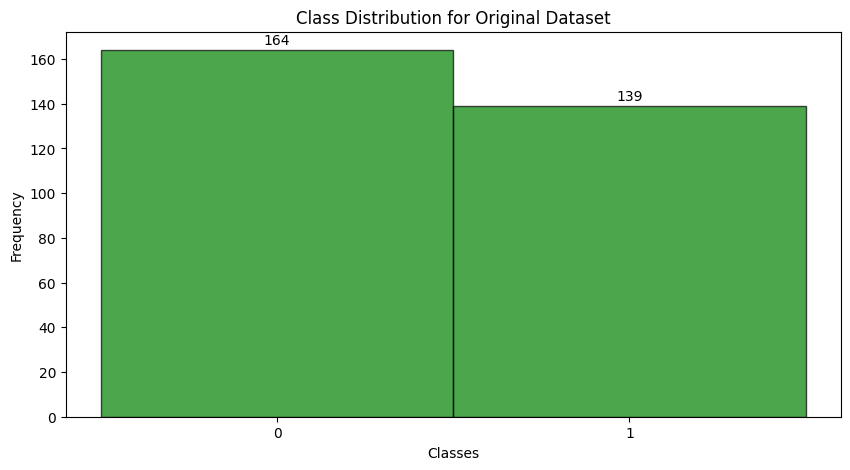

In [7]:
# Create directory to save distribution
os.makedirs("./Dataset 01/Distribution", exist_ok=True)

# Visualize the class distribution in the original dataset
plt.figure(figsize=(10, 5))
bins = np.arange(len(np.unique(raw_labels)) + 1) - 0.5
plt.hist(raw_labels, bins=bins, color="green", alpha=0.7, edgecolor="black")
plt.title("Class Distribution for Original Dataset")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.xticks(np.arange(len(np.unique(raw_labels))), np.unique(raw_labels))

unique_labels = np.unique(raw_labels)
for i, label in enumerate(unique_labels):
    count = np.sum(raw_labels == label)
    plt.text(i, count + 1, str(count), ha='center', va='bottom')

# Save the plots
plt.savefig("./Dataset 01/Distribution/Original Distribution.png", format='png', dpi=300)
plt.show()

#### 1.5.2. Split Dataset Class Distribution

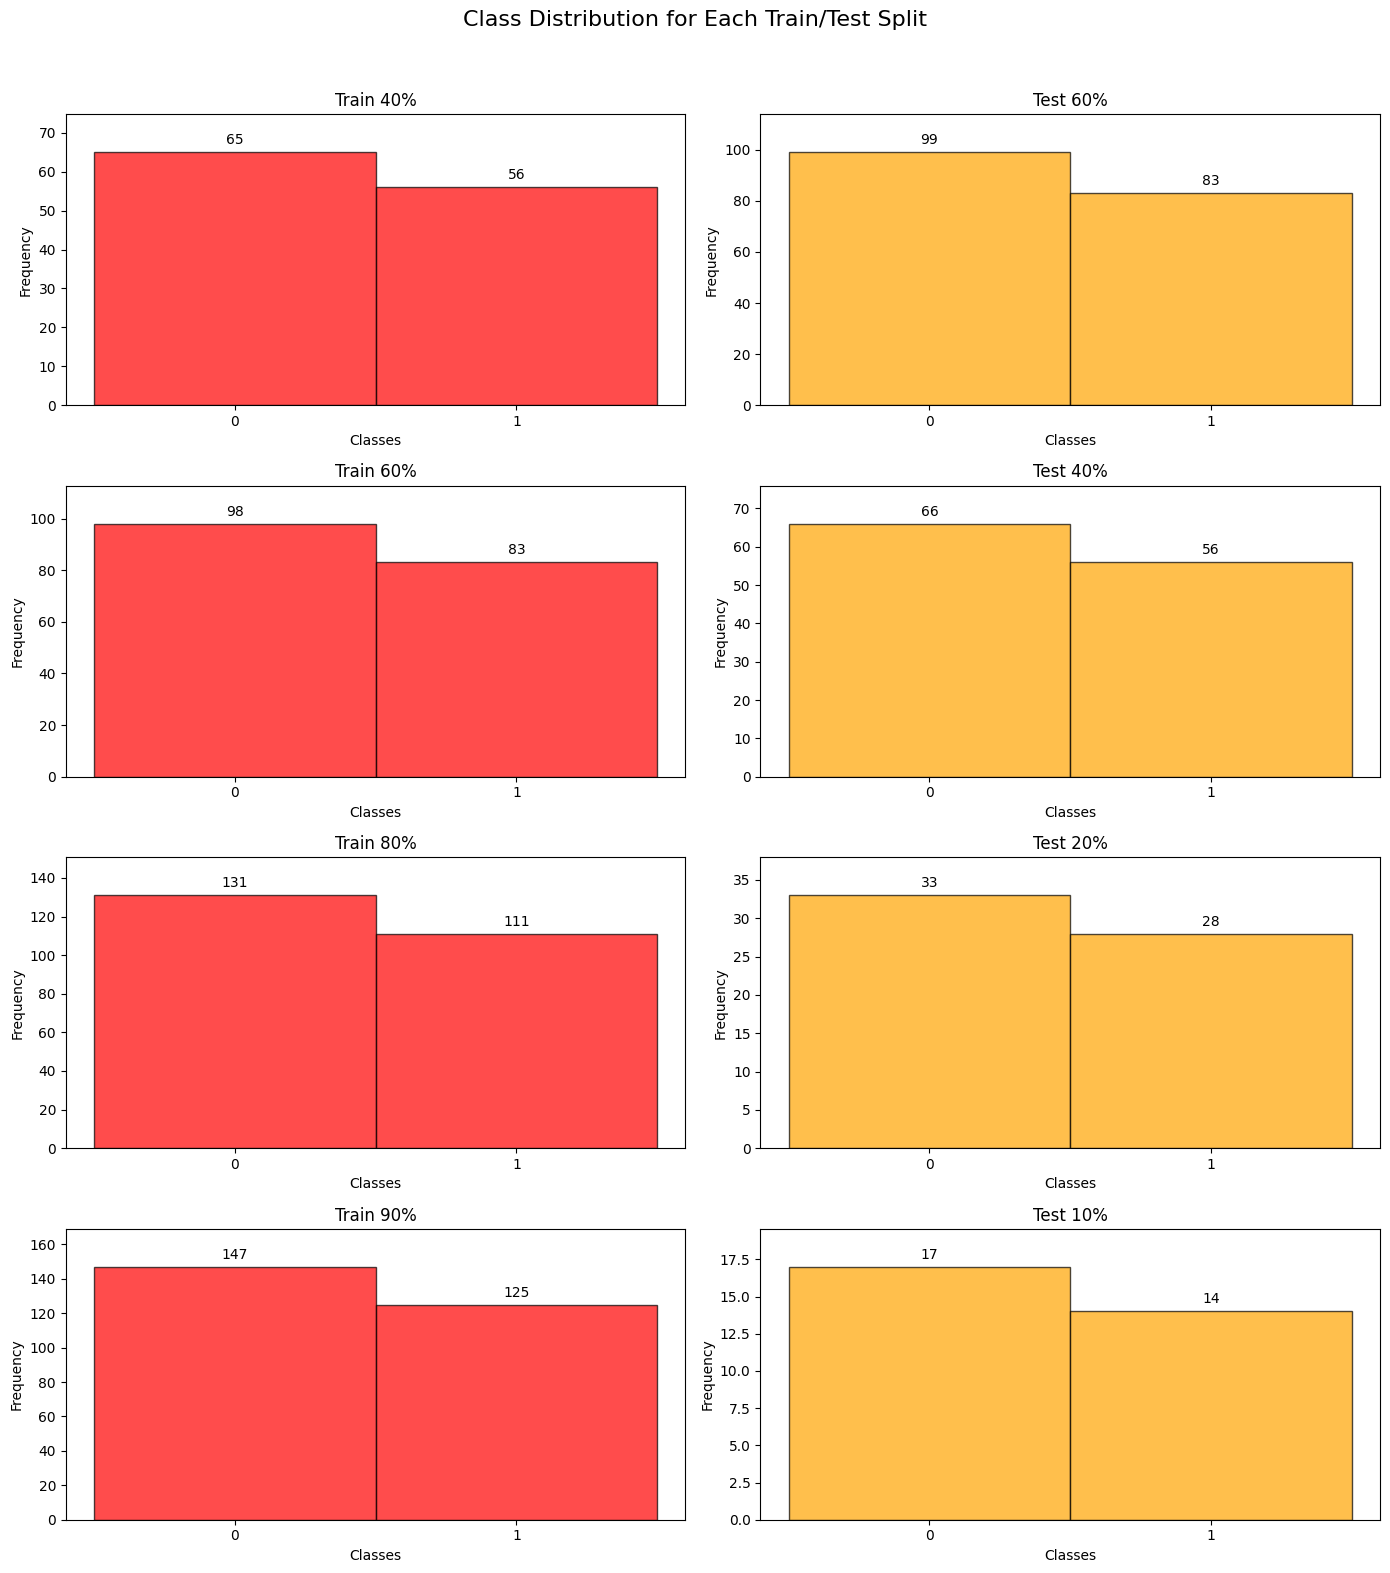

In [8]:
# Create a single figure with subplots arranged in 4 rows x 2 columns
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 16))
fig.suptitle("Class Distribution for Each Train/Test Split", fontsize=16)

# Get unique class labels and create bins
class_labels = np.unique(raw_labels)
bins = np.arange(len(class_labels) + 1) - 0.5 

# Visualize distributions for each train/test split
for i in range(len(subsets)):
    label_train = subsets[i]['label_train']
    label_test = subsets[i]['label_test']
    train_ratio = int(split_ratios[i][0] * 100)
    test_ratio = int(split_ratios[i][1] * 100)

    # Train distribution (left column)
    axes[i, 0].hist(label_train, bins=bins, color="red", alpha=0.7, edgecolor="black")
    axes[i, 0].set_title(f"Train {train_ratio}%")
    axes[i, 0].set_xticks(class_labels)
    axes[i, 0].set_xlabel("Classes")
    axes[i, 0].set_ylabel("Frequency")
    
    # Add count annotations on bars
    counts_train, _ = np.histogram(label_train, bins=bins)
    max_count_train = max(counts_train) if len(counts_train) > 0 else 0
    
    # Set y-axis limit with extra space for labels
    axes[i, 0].set_ylim(0, max_count_train * 1.15)  # 15% extra space
    
    for j, count in enumerate(counts_train):
        if count > 0: 
            axes[i, 0].text(class_labels[j], count + max_count_train * 0.02, 
                           str(count), ha='center', va='bottom', fontsize=10)

    # Test distribution (right column)
    axes[i, 1].hist(label_test, bins=bins, color="orange", alpha=0.7, edgecolor="black")
    axes[i, 1].set_title(f"Test {test_ratio}%")
    axes[i, 1].set_xticks(class_labels)
    axes[i, 1].set_xlabel("Classes")
    axes[i, 1].set_ylabel("Frequency")
    
    # Add count annotations on bars
    counts_test, _ = np.histogram(label_test, bins=bins)
    max_count_test = max(counts_test) if len(counts_test) > 0 else 0
    
    # Set y-axis limit with extra space for labels
    axes[i, 1].set_ylim(0, max_count_test * 1.15)  # 15% extra space
    
    for j, count in enumerate(counts_test):
        if count > 0:
            axes[i, 1].text(class_labels[j], count + max_count_test * 0.02, 
                           str(count), ha='center', va='bottom', fontsize=10)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the combined plot
plt.savefig("./Dataset 01/Distribution/Test and Train Distribution.png", format='png', dpi=300, bbox_inches='tight')
plt.show()

## **2. Implementing Decision Tree**

### **2.1. Train model for splits**

In [9]:
# Train and evaluate the Decision Tree model using Entropy (Information Gain)
models = []
for i, subset in enumerate(subsets):
    feature_train = subset['feature_train']
    label_train = subset['label_train']
    model = DecisionTreeClassifier(criterion='entropy', random_state=45)
    model.fit(feature_train, label_train)
    models.append(model)

### **2.2. Visualization**

Decision tree trained with a train/test split of 40_60


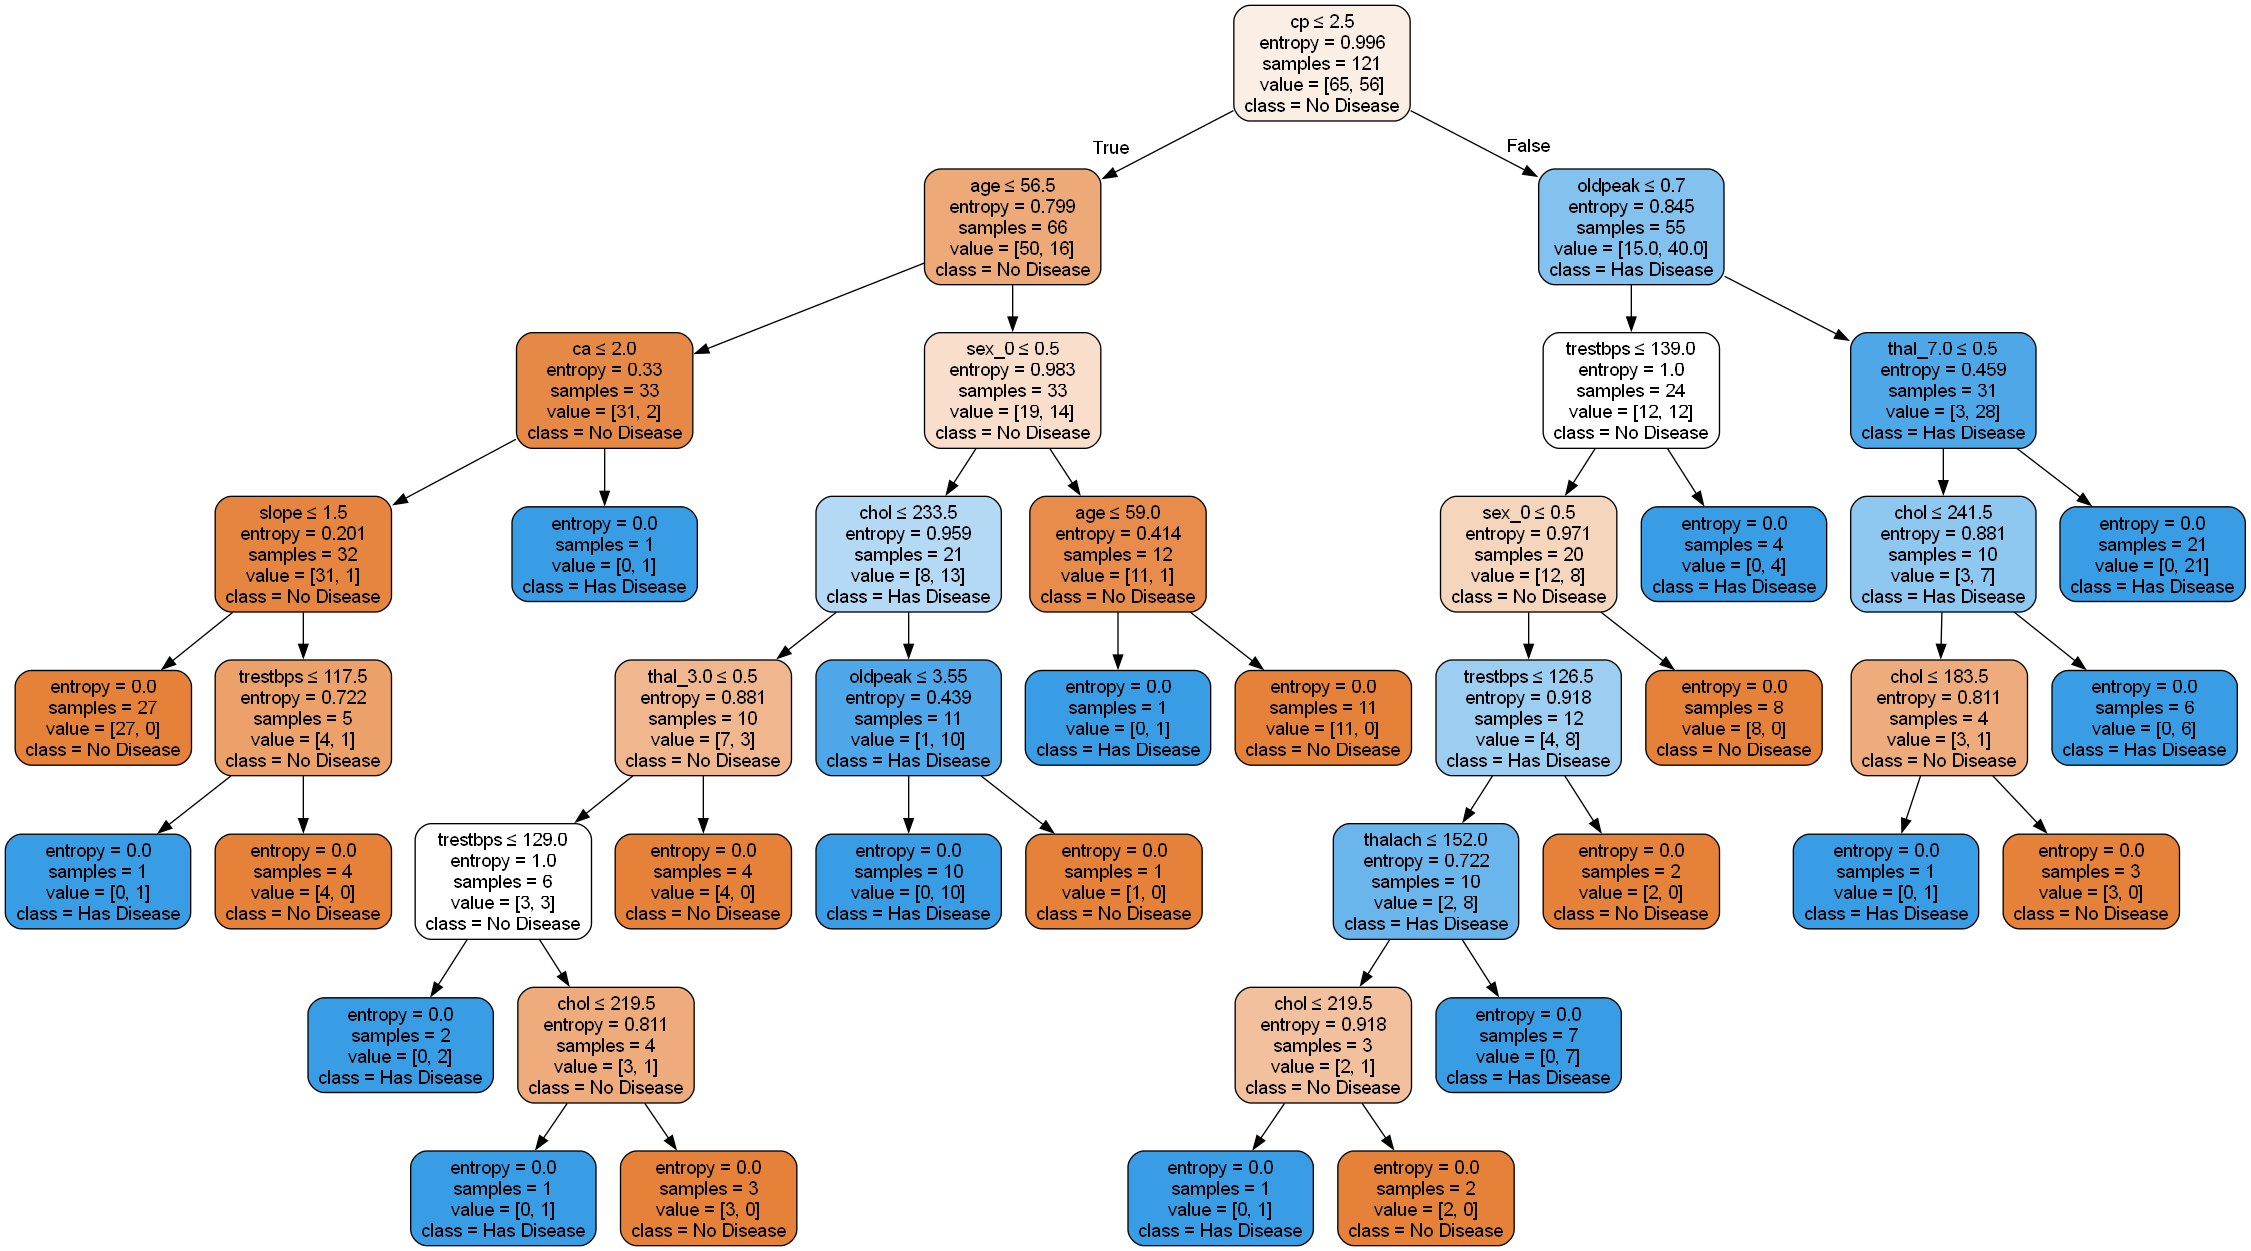

----------------------------------------------------------------------------------------------------
Decision tree trained with a train/test split of 60_40


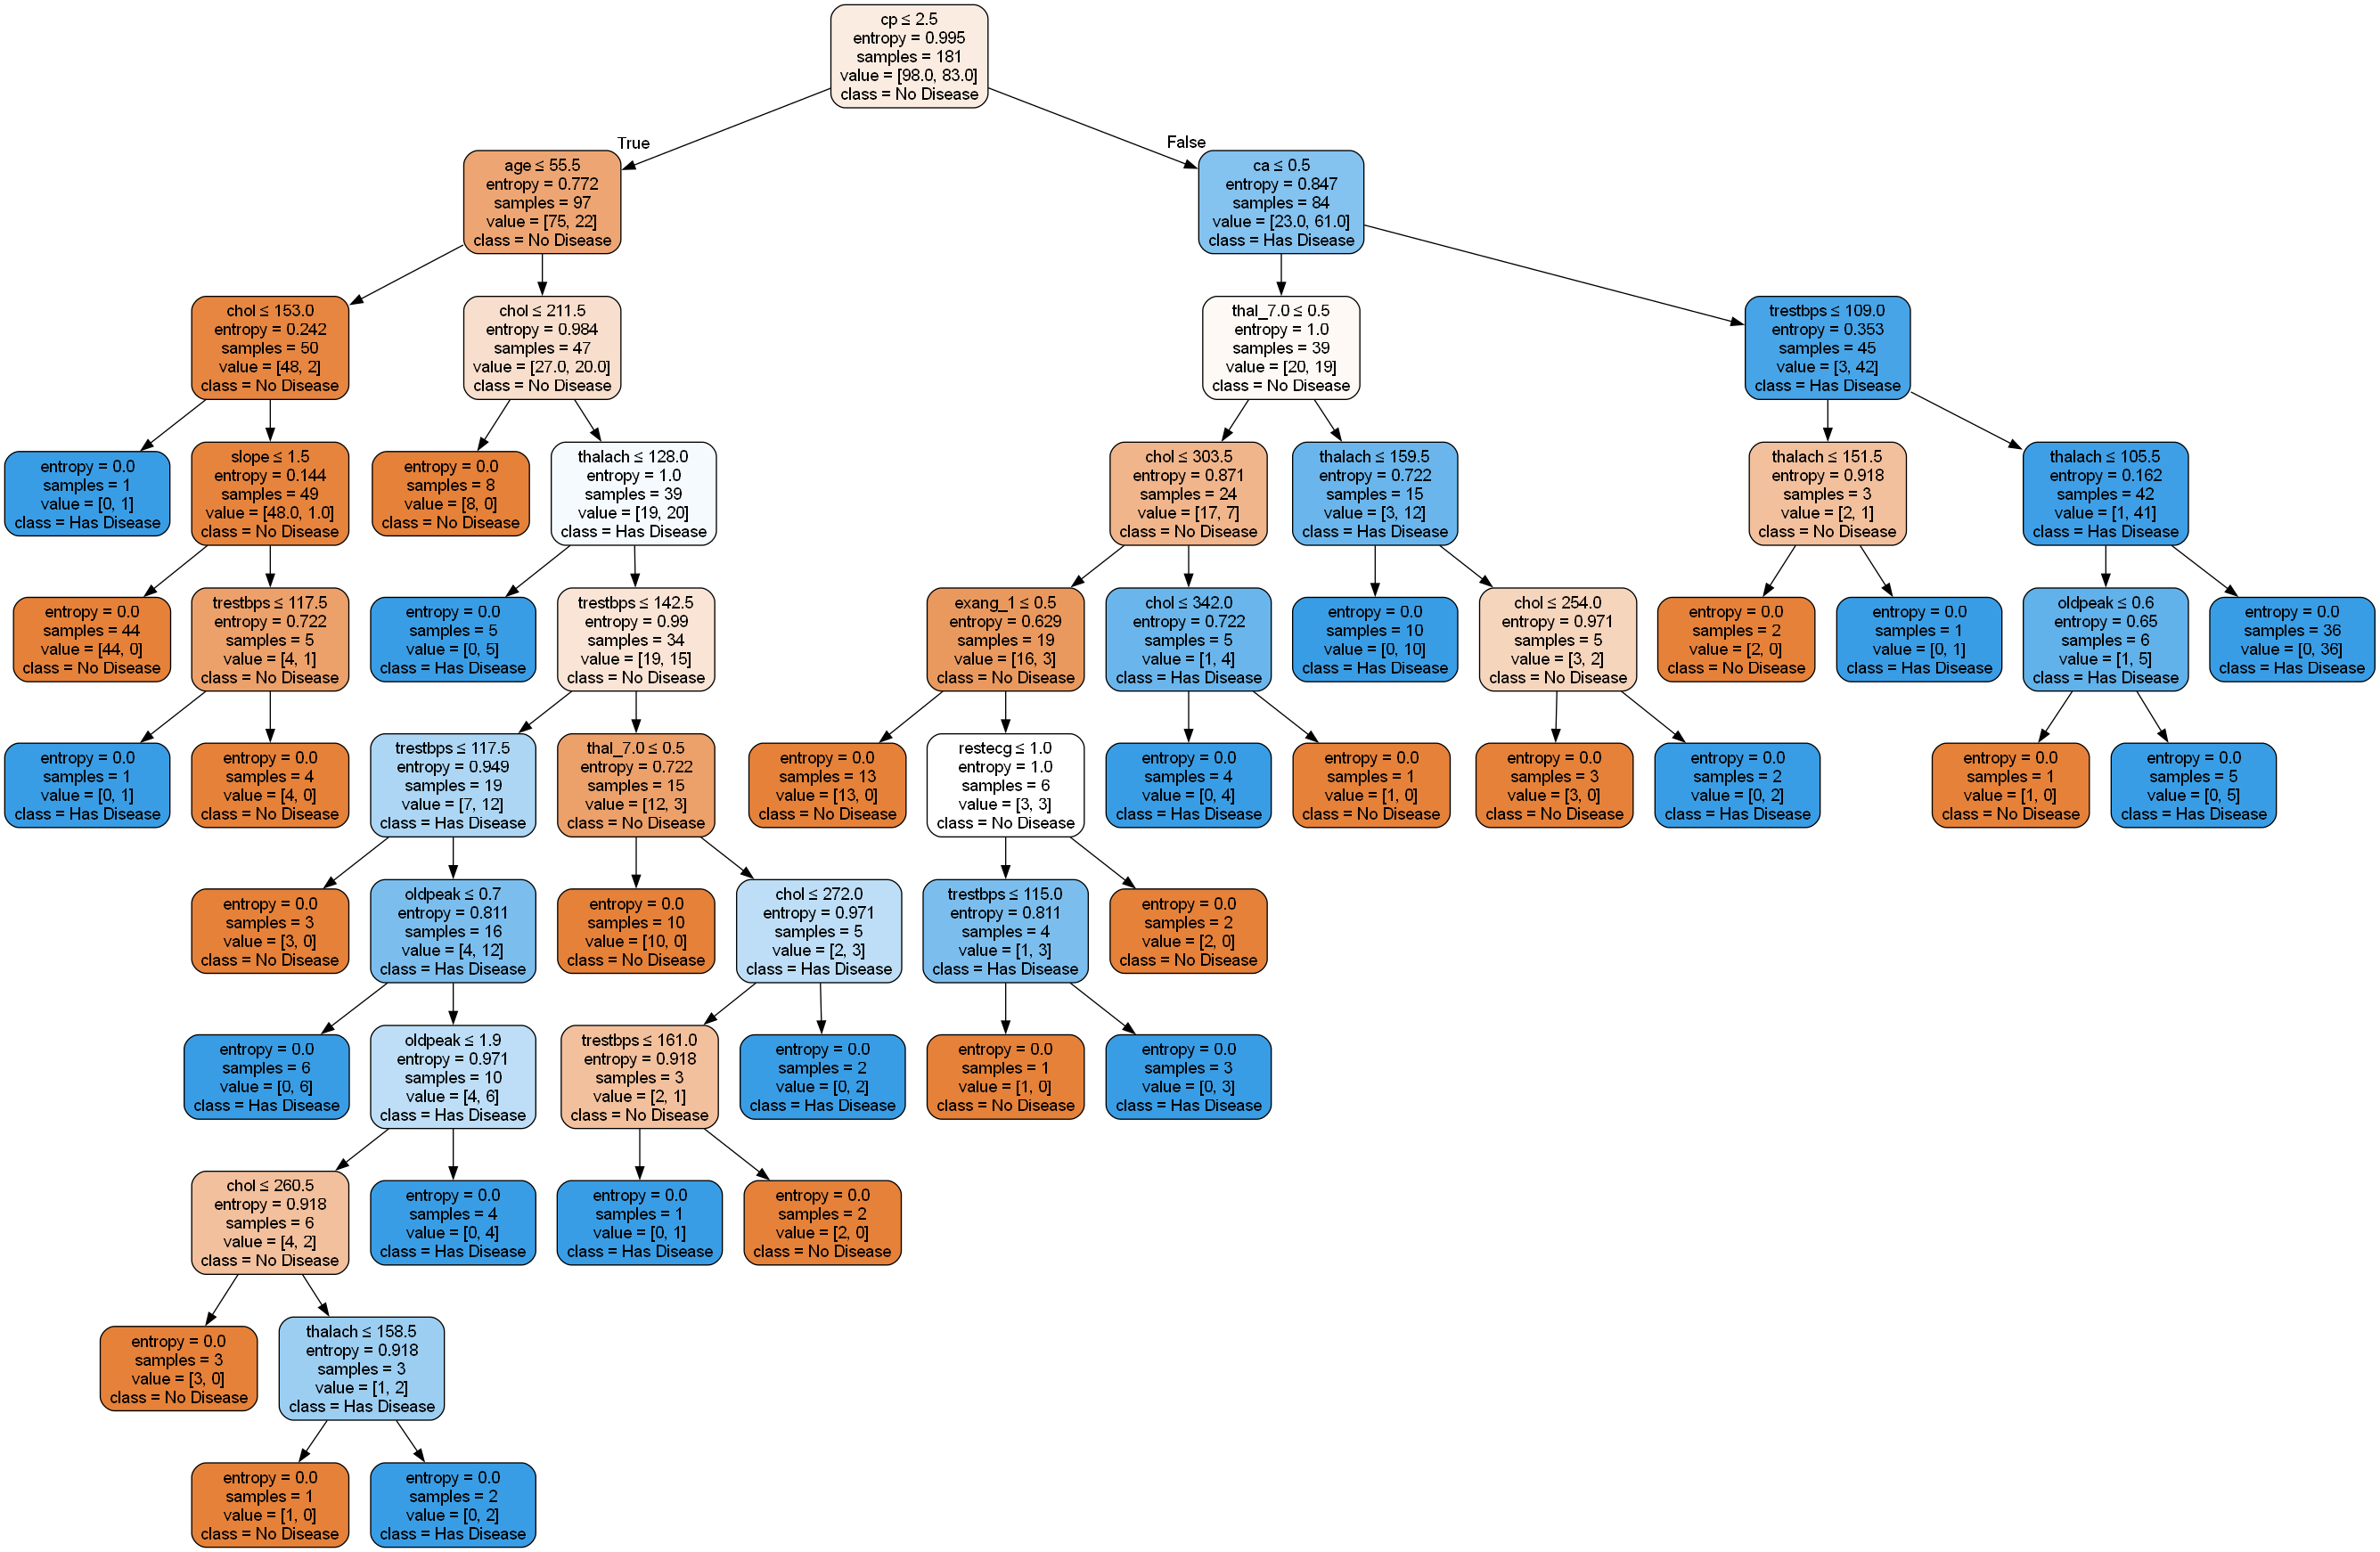

----------------------------------------------------------------------------------------------------
Decision tree trained with a train/test split of 80_20


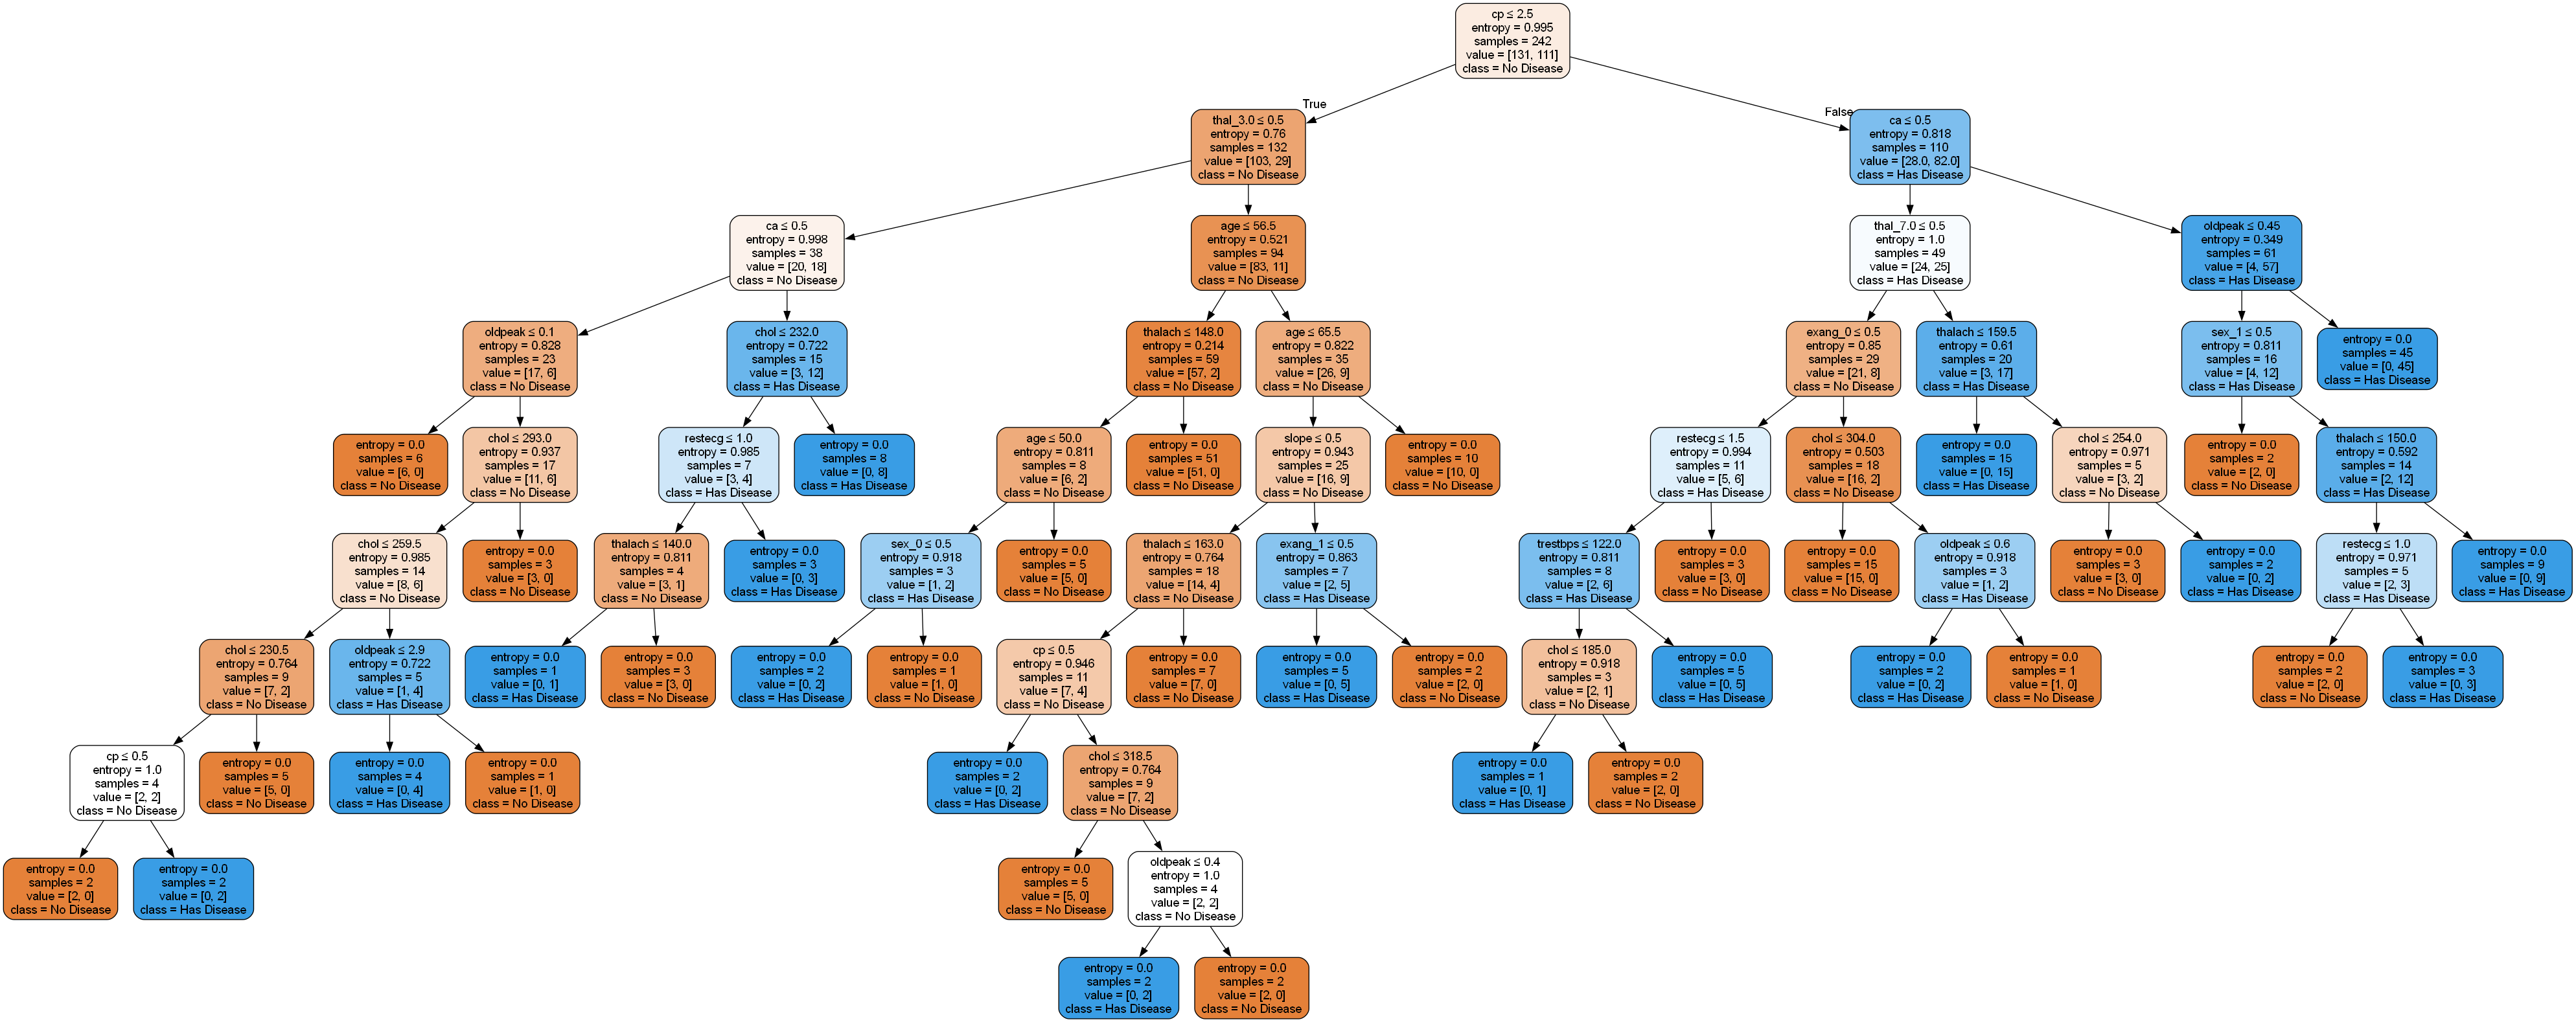

----------------------------------------------------------------------------------------------------
Decision tree trained with a train/test split of 90_10


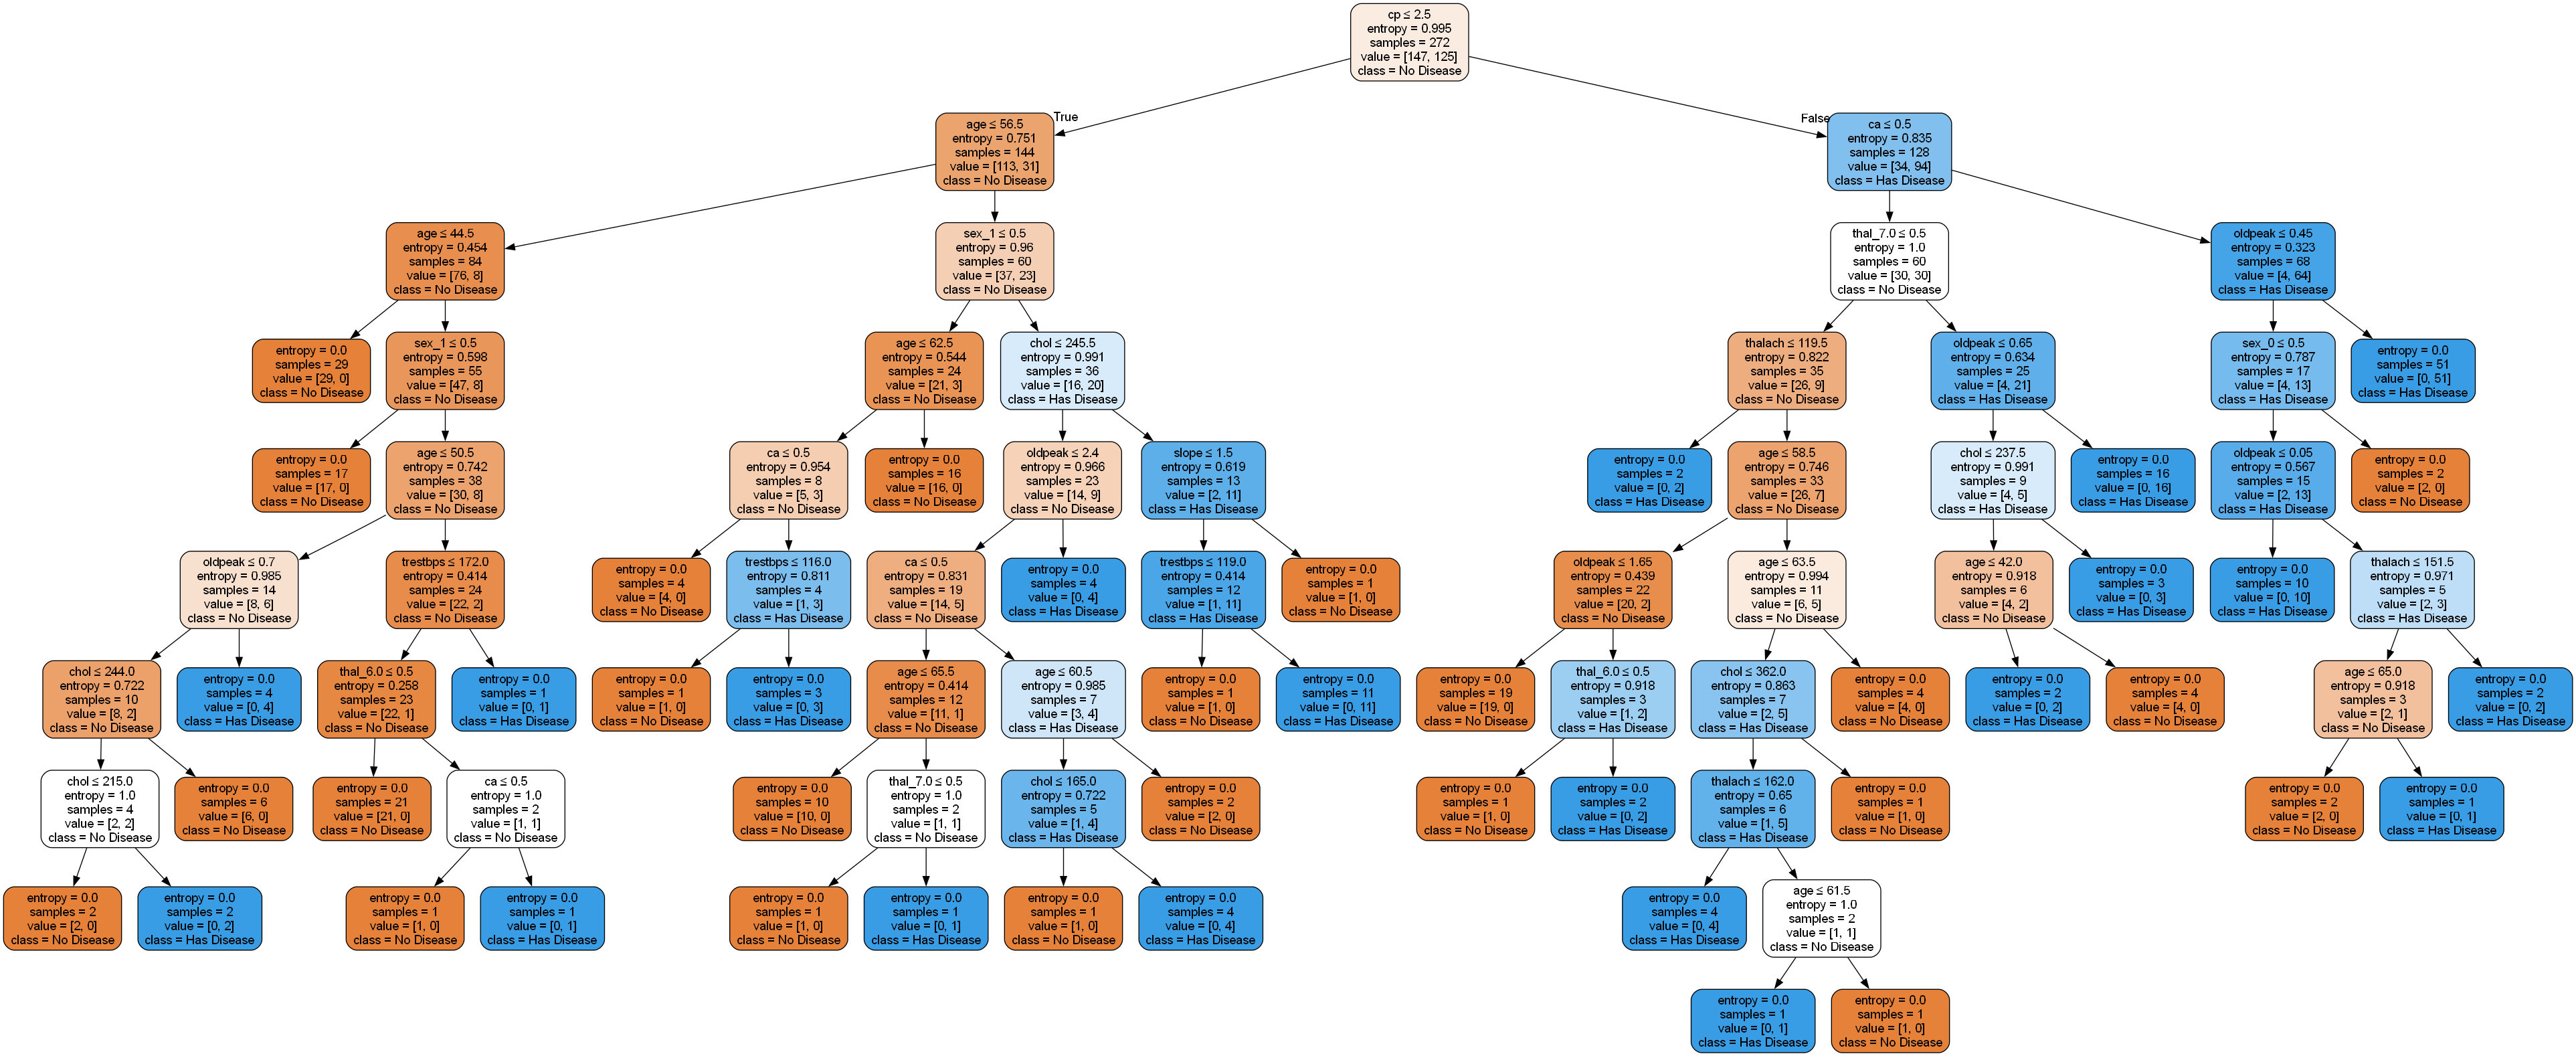

In [10]:
# Create directory to save the decision tree images
os.makedirs("./Dataset 01/Decision Tree", exist_ok=True)

# Create and visualize decision trees for each model
for i in range(len(models)):
    ratio_name = f"{int(split_ratios[i][0]*100)}_{int(split_ratios[i][1]*100)}"

    print(f"Decision tree trained with a train/test split of {ratio_name}")

    # Get the model and feature names
    model = models[i]
    feature_names = feature_train.columns.tolist()

    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=feature_names,
        class_names=['No Disease', 'Has Disease'],
        filled=True,
        rounded=True,
        special_characters=True
    )

    # Visualize the decision tree
    graph = Source(dot_data)
    file_path = f"./Dataset 01/Decision Tree/Tree_{ratio_name}"
    graph.render(file_path, format='png', cleanup=True)
    display(Image(file_path + ".png"))
    
    if(i != len(subsets) - 1):
        print('-' * 100)

## **3. Evaluating Decision Trees**


Classification Report for 40_60 Split:
              precision    recall  f1-score   support

  No Disease       0.77      0.73      0.75        99
 Has Disease       0.69      0.73      0.71        83

    accuracy                           0.73       182
   macro avg       0.73      0.73      0.73       182
weighted avg       0.73      0.73      0.73       182



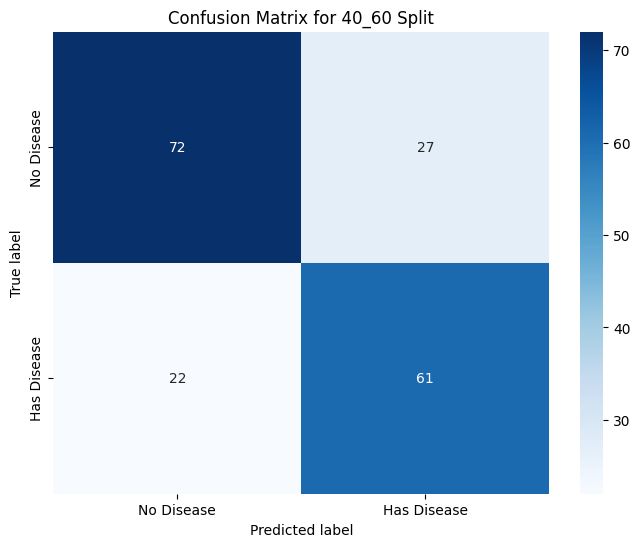

----------------------------------------------------------------------------------------------------

Classification Report for 60_40 Split:
              precision    recall  f1-score   support

  No Disease       0.77      0.77      0.77        66
 Has Disease       0.73      0.73      0.73        56

    accuracy                           0.75       122
   macro avg       0.75      0.75      0.75       122
weighted avg       0.75      0.75      0.75       122



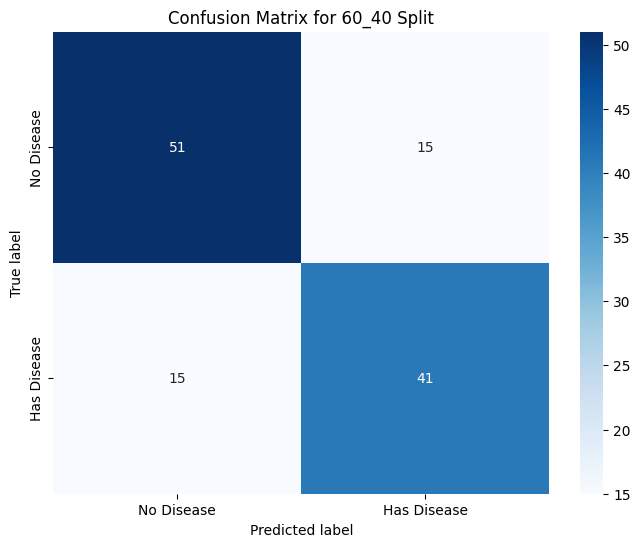

----------------------------------------------------------------------------------------------------

Classification Report for 80_20 Split:
              precision    recall  f1-score   support

  No Disease       0.81      0.76      0.78        33
 Has Disease       0.73      0.79      0.76        28

    accuracy                           0.77        61
   macro avg       0.77      0.77      0.77        61
weighted avg       0.77      0.77      0.77        61



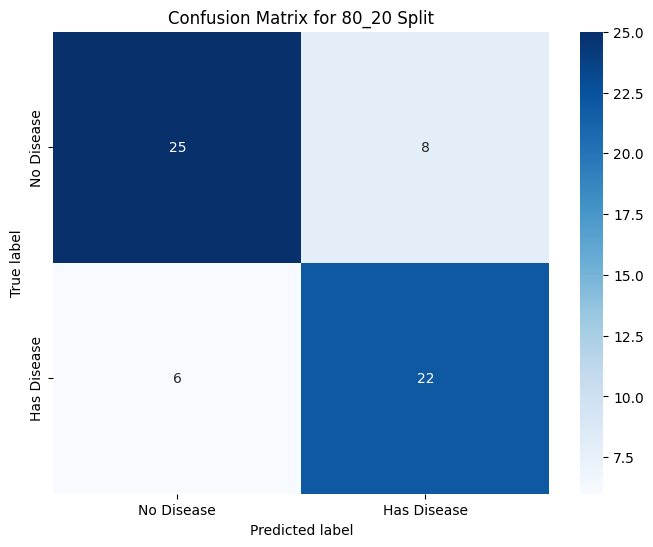

----------------------------------------------------------------------------------------------------

Classification Report for 90_10 Split:
              precision    recall  f1-score   support

  No Disease       0.88      0.88      0.88        17
 Has Disease       0.86      0.86      0.86        14

    accuracy                           0.87        31
   macro avg       0.87      0.87      0.87        31
weighted avg       0.87      0.87      0.87        31



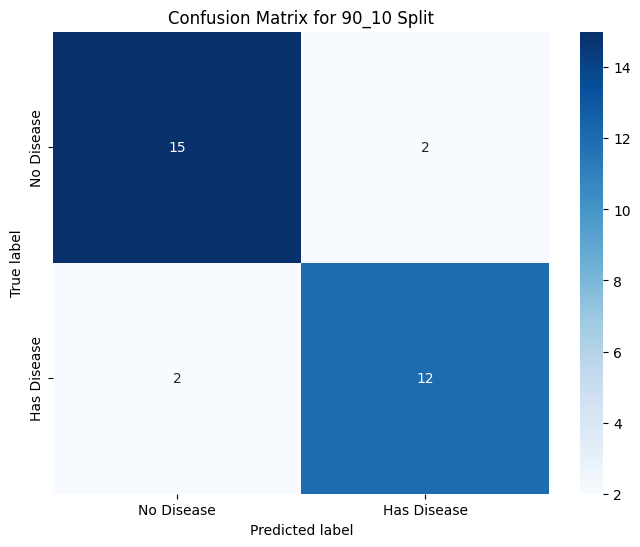

In [11]:
# Create directory to save classification and confusion matrices
os.makedirs("./Dataset 01/Evaluation", exist_ok=True)


# For each model and split, make predictions, generate a report, and confusion matrix
for i, subset in enumerate(subsets):
    feature_train = subset['feature_train']
    label_train = subset['label_train']
    feature_test = subset['feature_test']
    label_test = subset['label_test']
    
    # Make predictions
    label_pred = models[i].predict(feature_test)
    
    # Generate classification report
    ratio_name = f"{int(split_ratios[i][0]*100)}_{int(split_ratios[i][1]*100)}"

    print(f"\nClassification Report for {ratio_name} Split:")
    report_text = classification_report(label_test, label_pred, target_names=['No Disease', 'Has Disease'])
    print(report_text)

    # Save classification report to a text file
    with open(f"./Dataset 01/Evaluation/Report_{ratio_name}.txt", "w") as f:
        f.write(report_text)

    # Generate confusion matrix
    cm = confusion_matrix(label_test, label_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['No Disease', 'Has Disease'],
                yticklabels=['No Disease', 'Has Disease'])
    plt.title(f"Confusion Matrix for {ratio_name} Split")
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

     
    # Save confusion matrix plot
    plt.savefig(f"./Dataset 01/Evaluation/Confusion_{ratio_name}.png", format='png',dpi=300, bbox_inches='tight')
    plt.show()
    if(i != len(subsets) - 1):
        print('-' * 100)

## **4. Depth and Accuracy of a Decision Tree** 

Decision tree trained with an 80/20 split and max depth of None


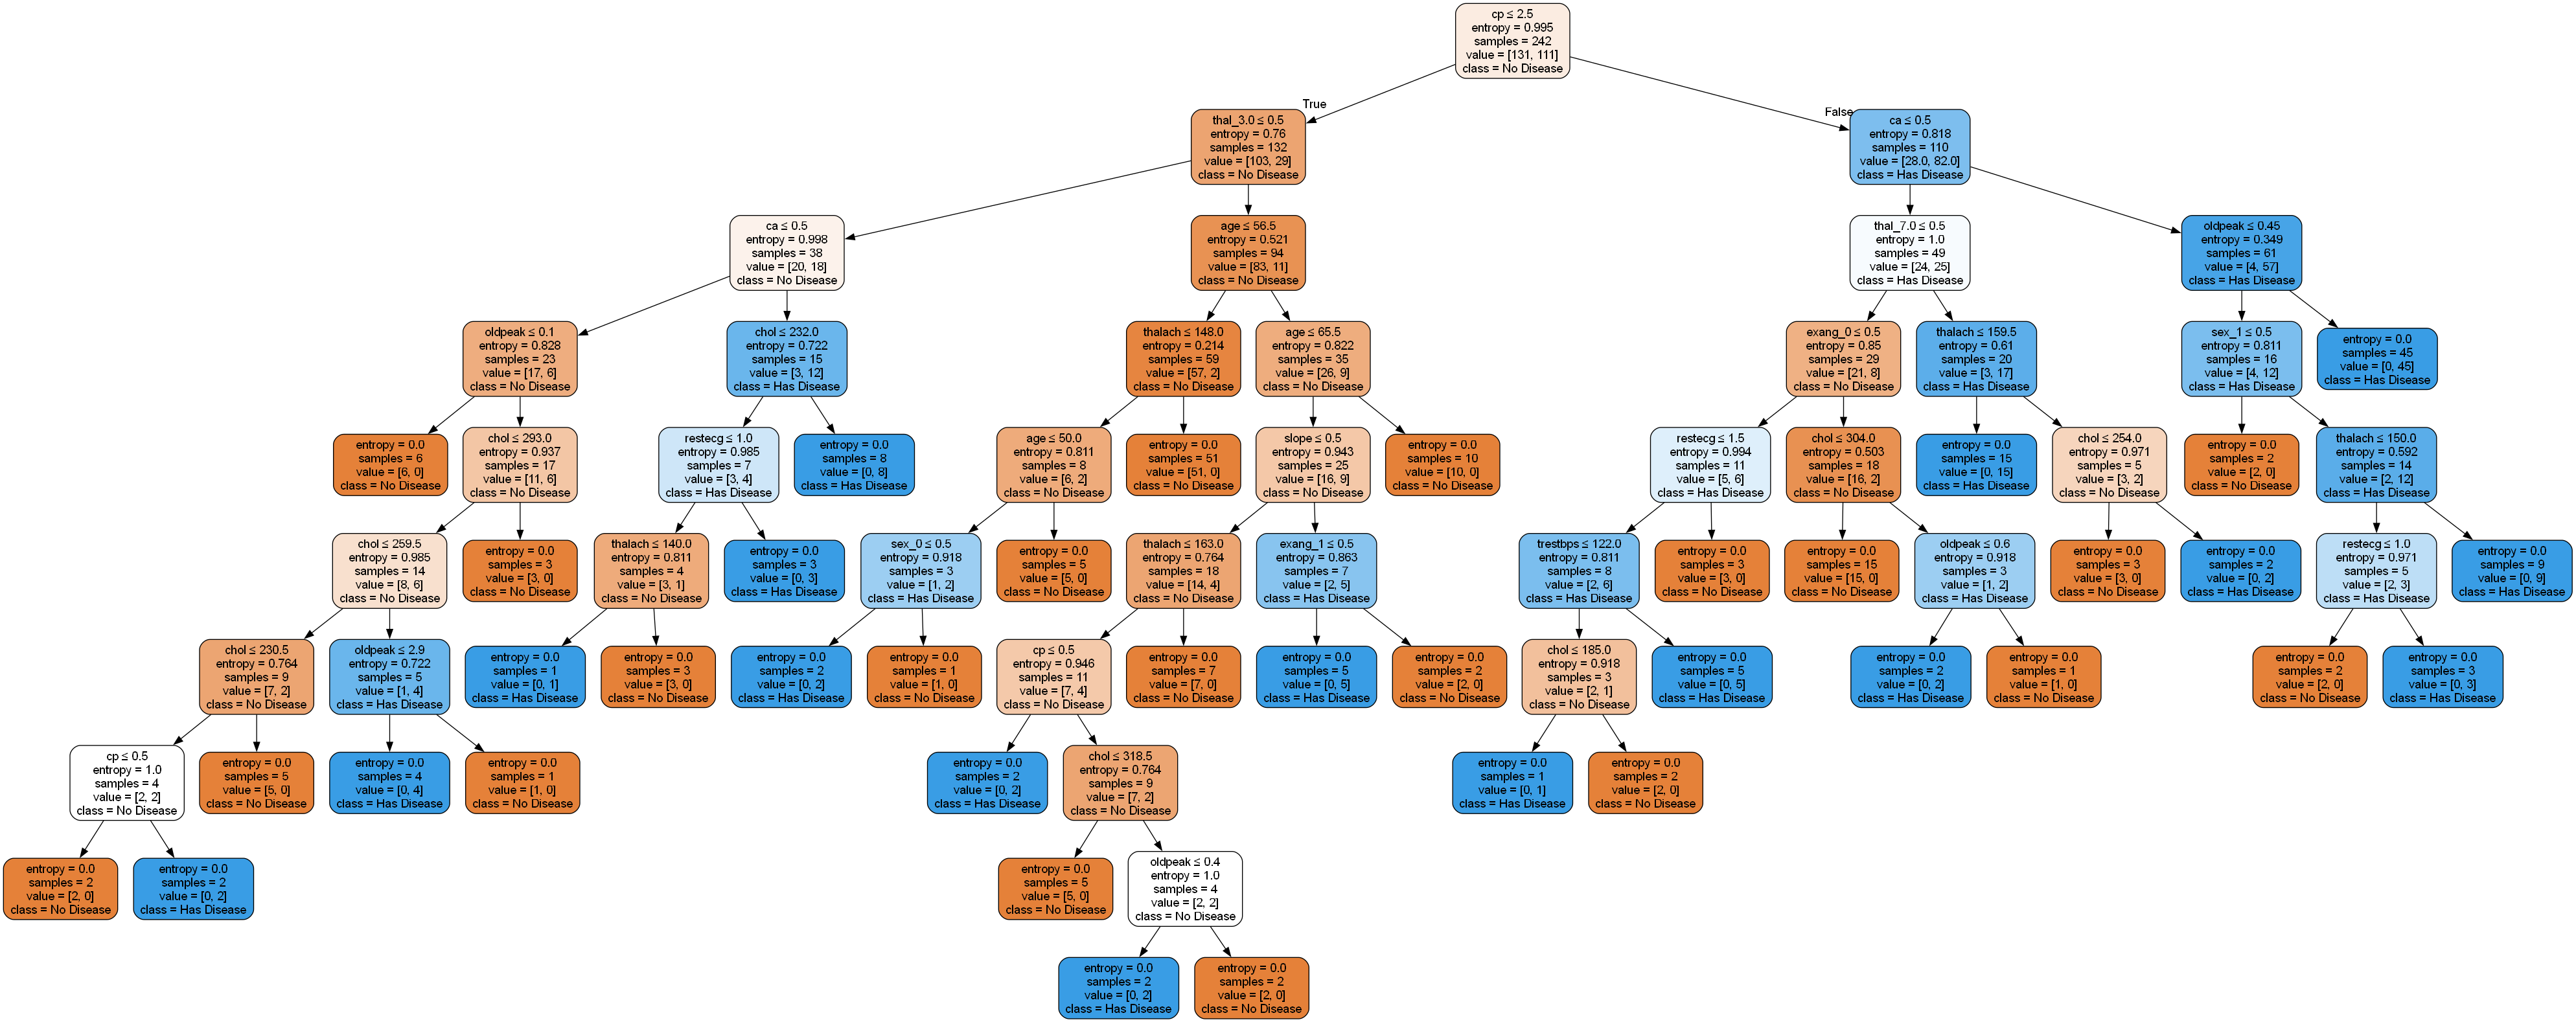

Accuracy for max depth None: 0.7704918032786885
----------------------------------------------------------------------------------------------------
Decision tree trained with an 80/20 split and max depth of 2


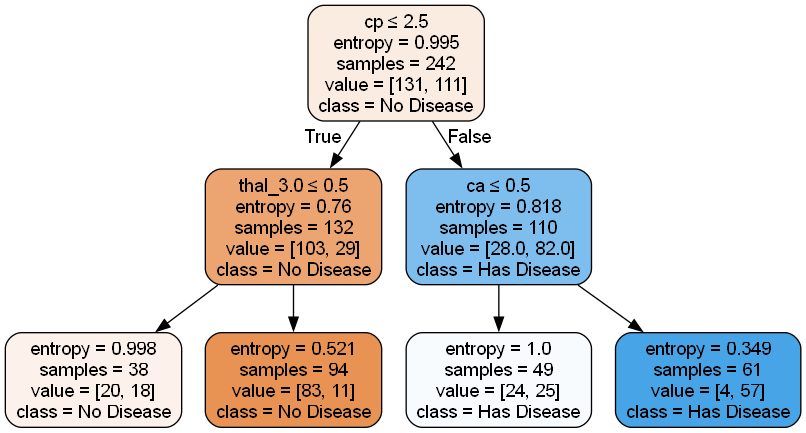

Accuracy for max depth 2: 0.7377049180327869
----------------------------------------------------------------------------------------------------
Decision tree trained with an 80/20 split and max depth of 3


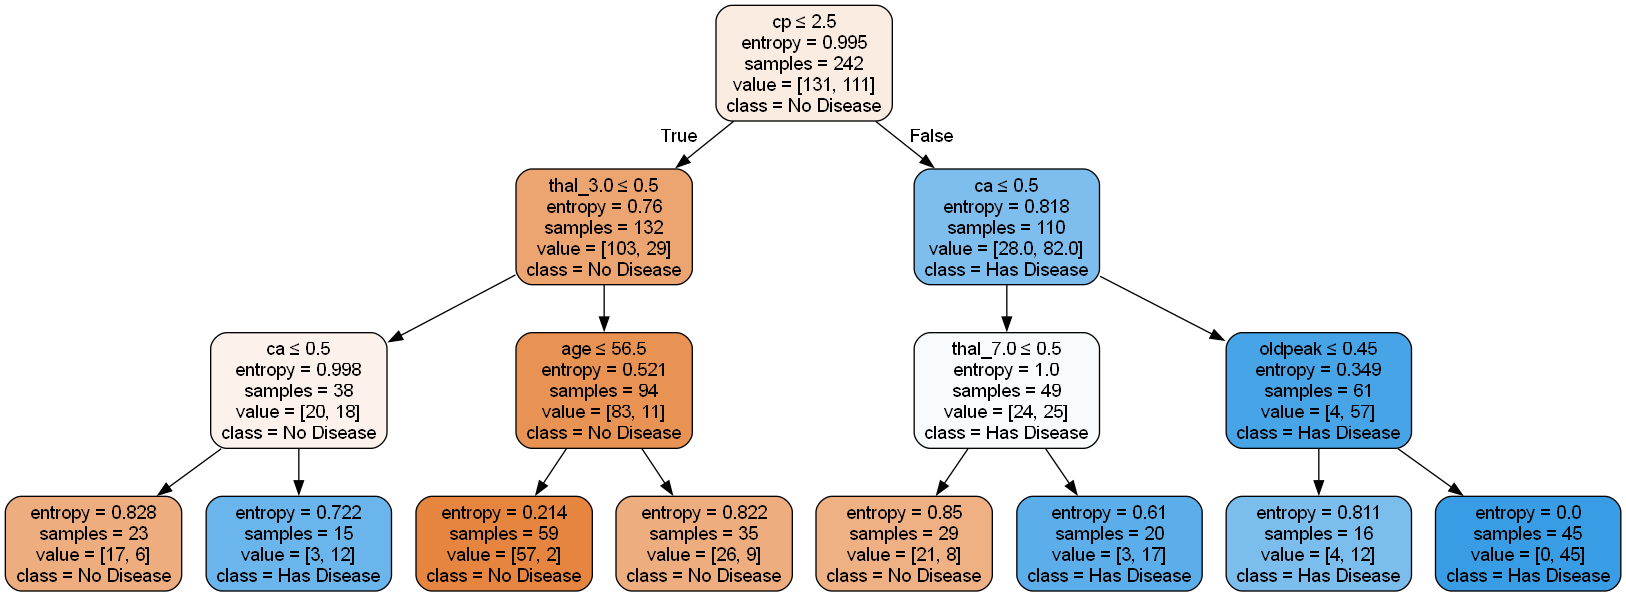

Accuracy for max depth 3: 0.8360655737704918
----------------------------------------------------------------------------------------------------
Decision tree trained with an 80/20 split and max depth of 4


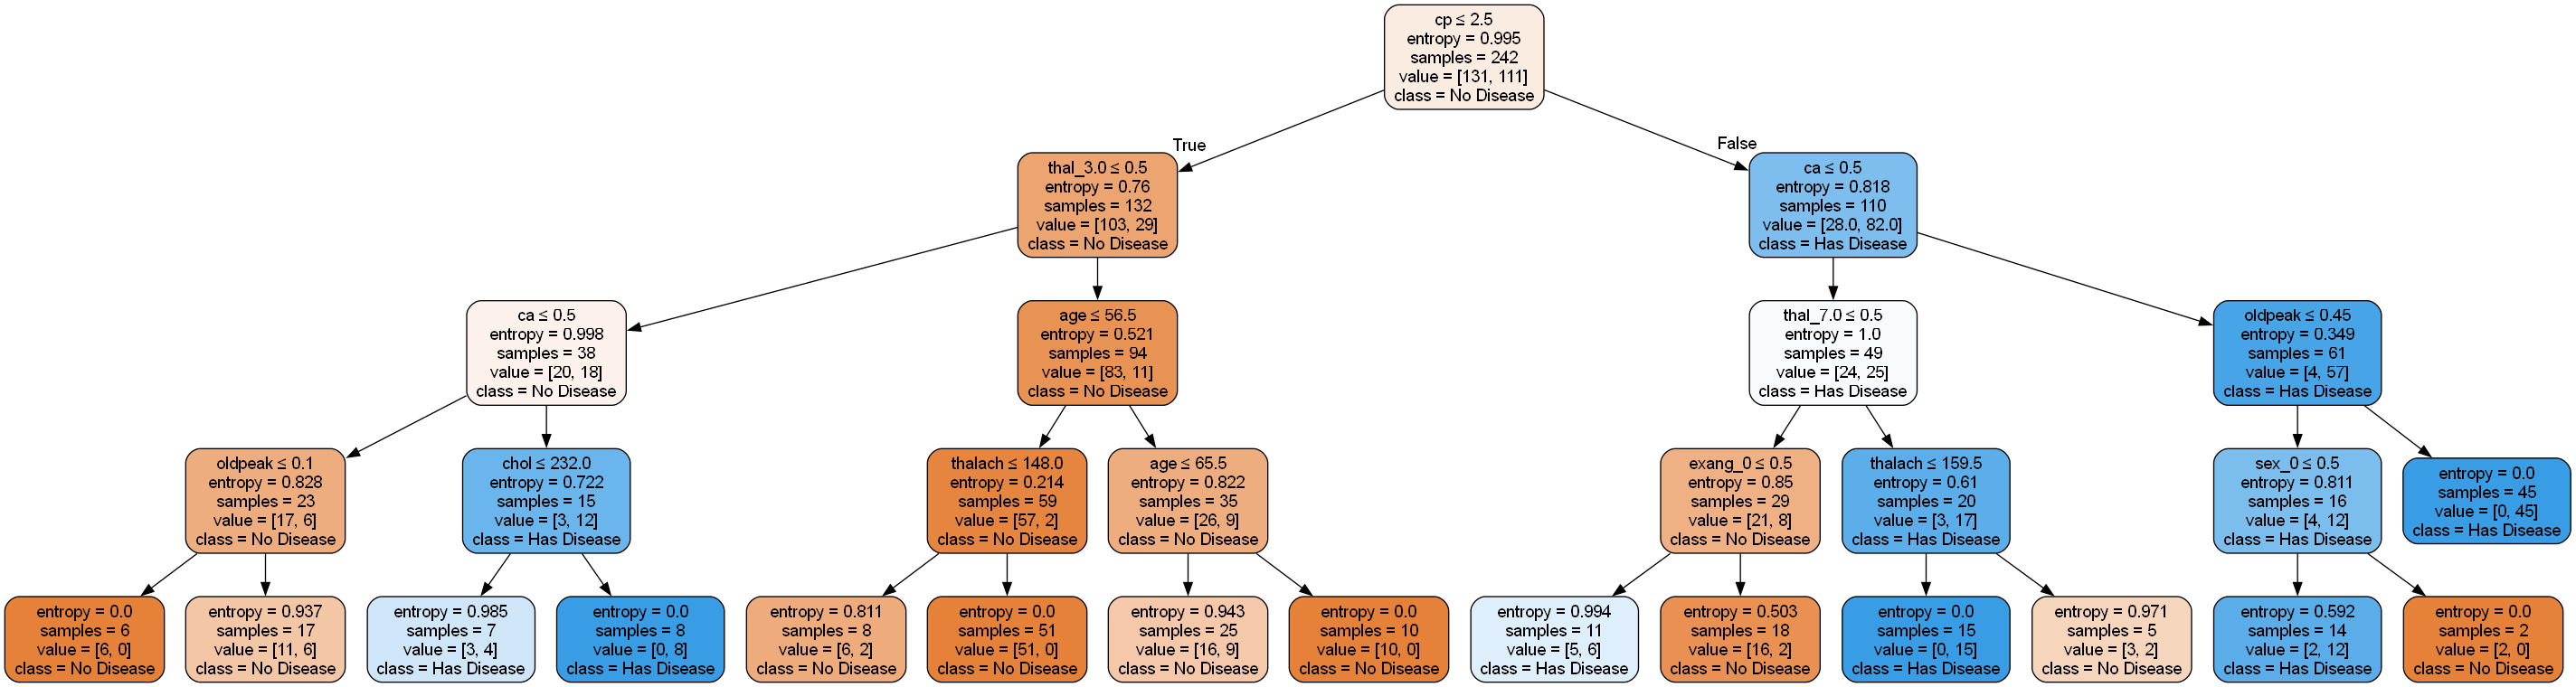

Accuracy for max depth 4: 0.8032786885245902
----------------------------------------------------------------------------------------------------
Decision tree trained with an 80/20 split and max depth of 5


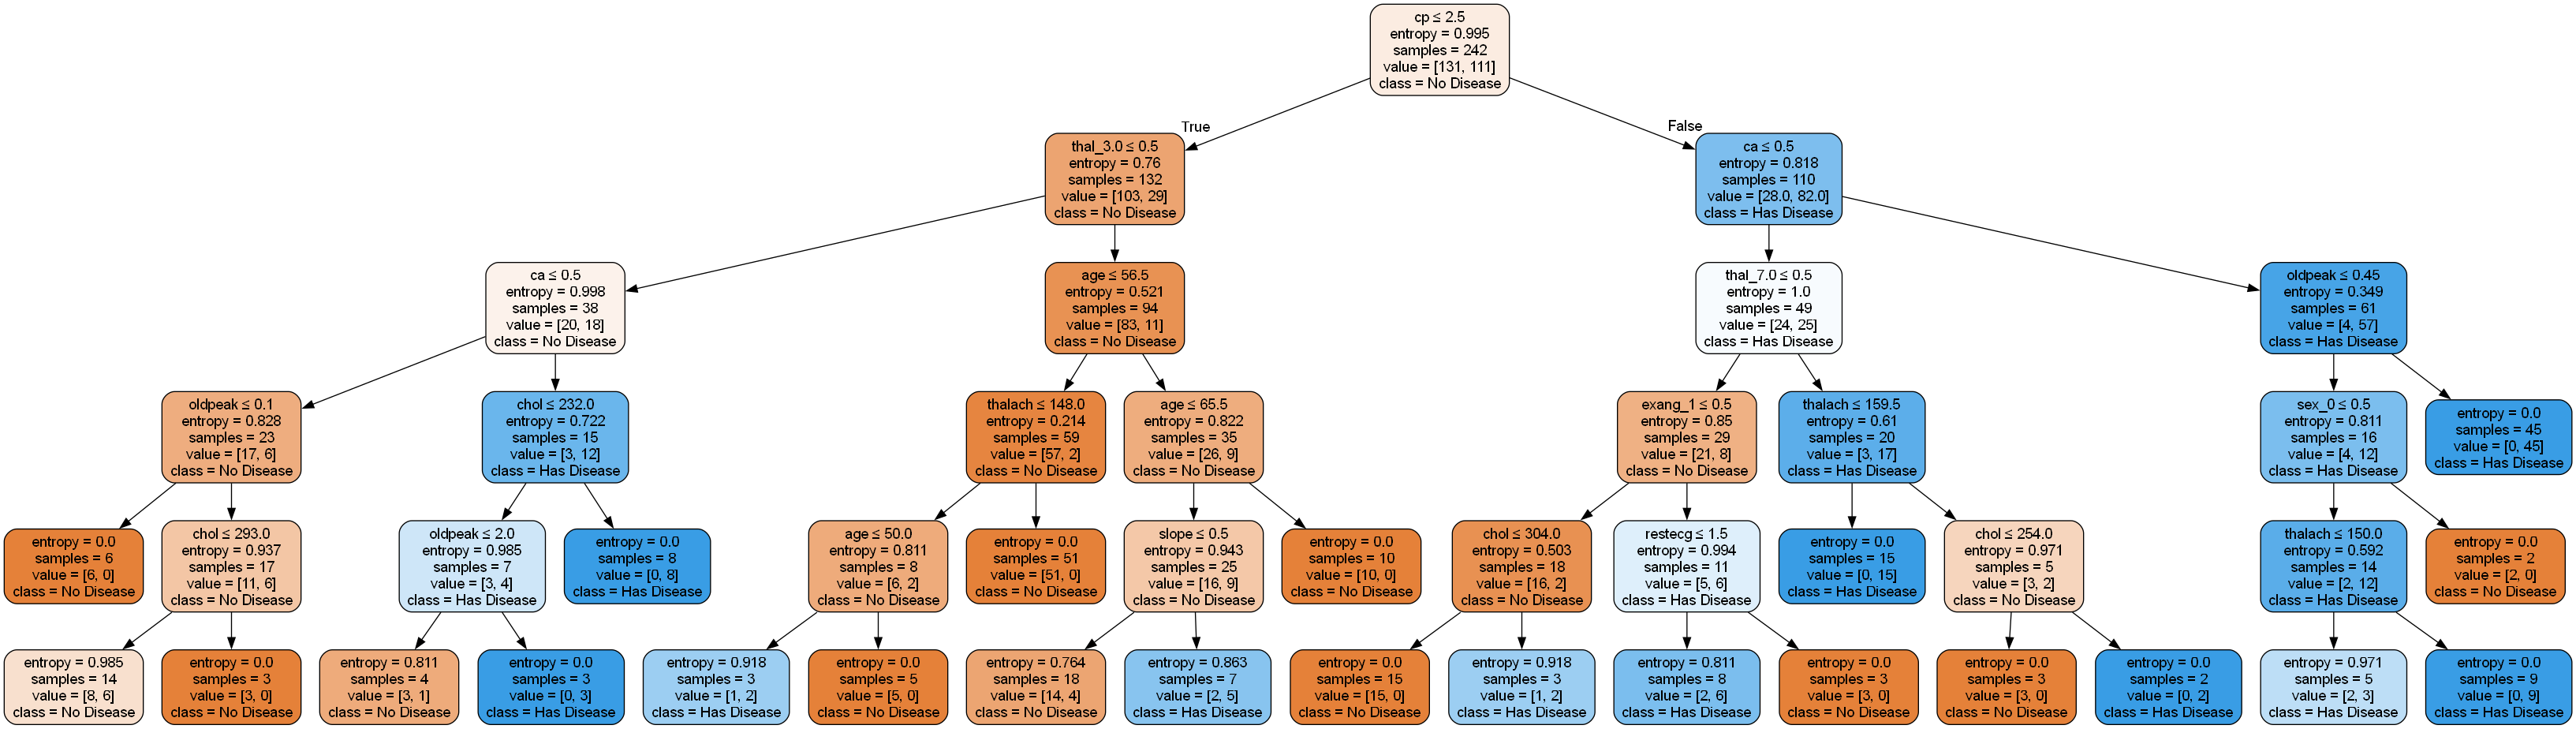

Accuracy for max depth 5: 0.7868852459016393
----------------------------------------------------------------------------------------------------
Decision tree trained with an 80/20 split and max depth of 6


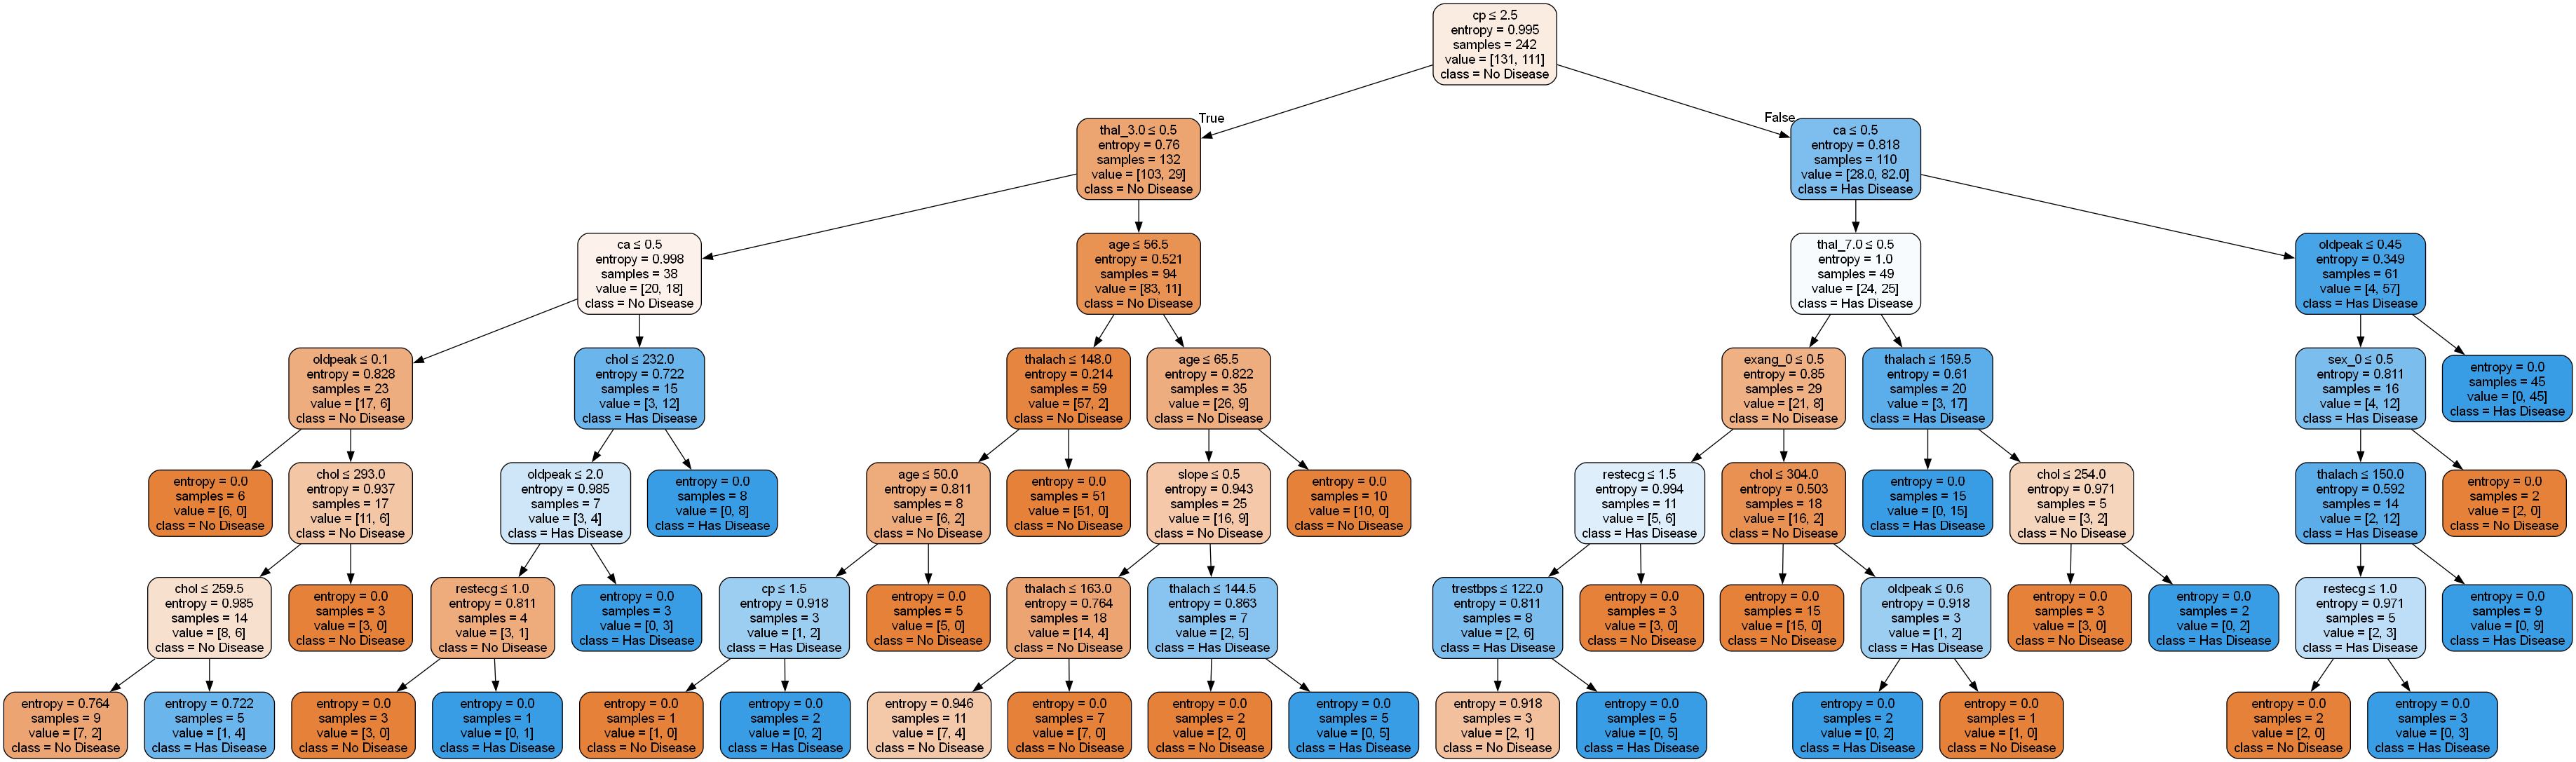

Accuracy for max depth 6: 0.7868852459016393
----------------------------------------------------------------------------------------------------
Decision tree trained with an 80/20 split and max depth of 7


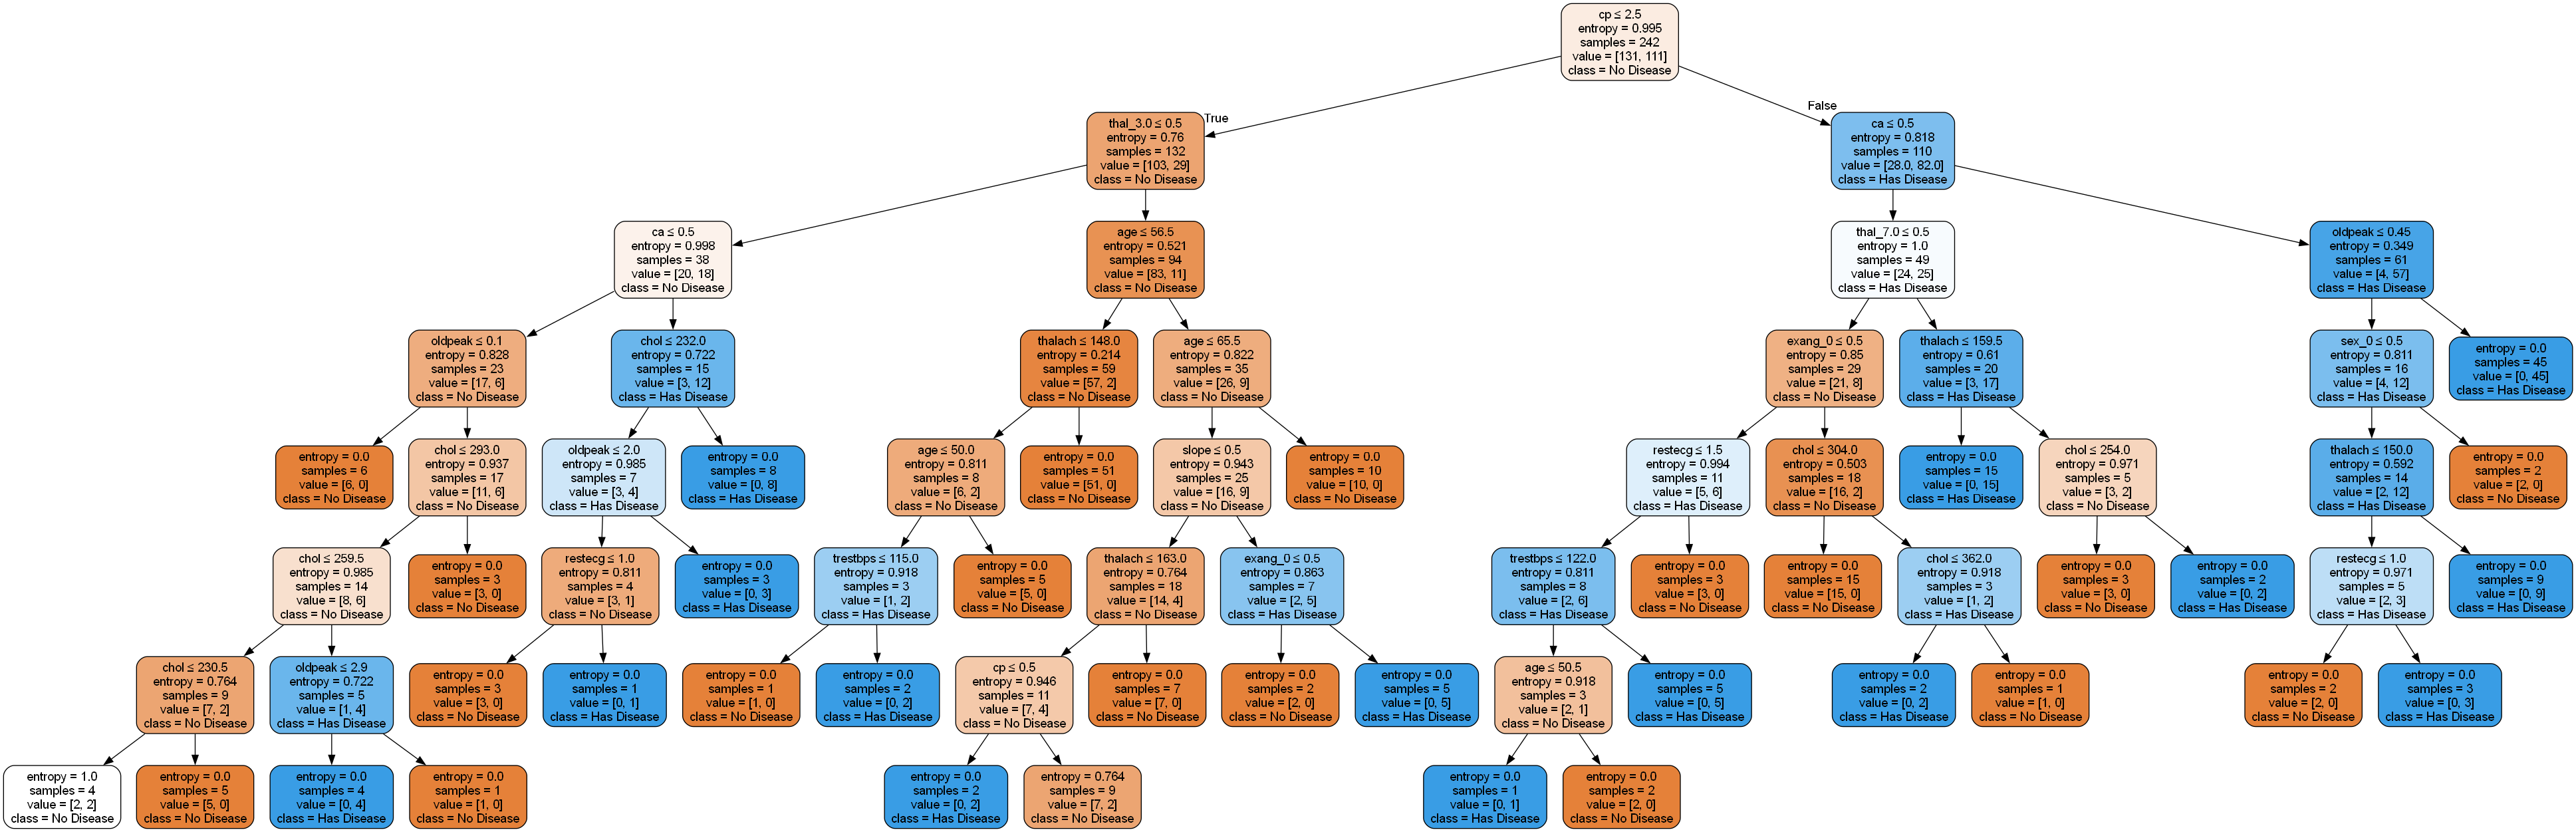

Accuracy for max depth 7: 0.7704918032786885
----------------------------------------------------------------------------------------------------


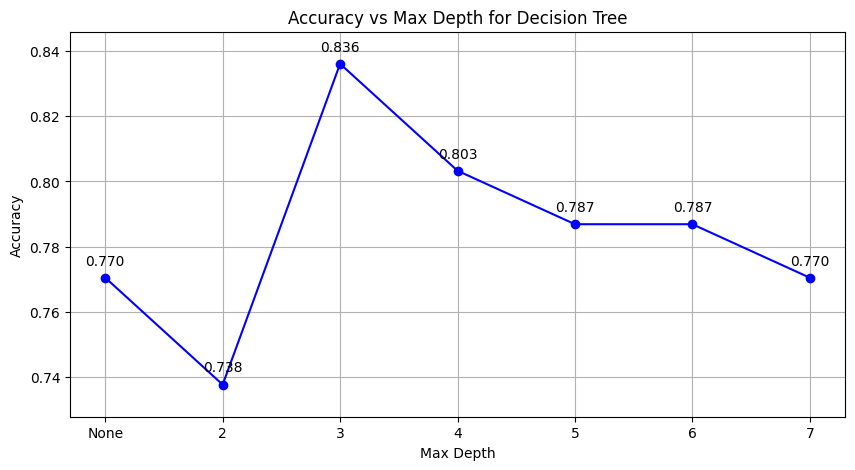

None      2      3      4      5      6      7
Accuracy  0.770  0.738  0.836  0.803  0.787  0.787  0.770

In [12]:
#Create directory for save decision tree images with max depth
os.makedirs("./Dataset 01/Depth and Accuracy", exist_ok=True)

# Train and evaluate Decision Tree models with varying max depths on the 80/20 split
subset_80_20 = subsets[2]
feature_train_80_20 = subsets[2]['feature_train']
label_train_80_20 = subset_80_20['label_train']
feature_test_80_20 = subset_80_20['feature_test']
label_test_80_20 = subset_80_20['label_test']
accuracy_scores = []
depths = [None, 2, 3, 4, 5, 6, 7]

for depth in depths:
    model = DecisionTreeClassifier(criterion='entropy', random_state=45, max_depth=depth)
    model.fit(feature_train_80_20, label_train_80_20)
    feature_names = feature_train.columns.astype(str).tolist() 
    print(f"Decision tree trained with an 80/20 split and max depth of {depth}")
    

    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=feature_names,
        class_names=['No Disease', 'Has Disease'],
        filled=True,
        rounded=True,
        special_characters=True
    )
    
    # Visualize the decision tree
    graph = Source(dot_data)
    file_path = f"./Dataset 01/Depth and Accuracy/Tree_Depth_{depth}"
    graph.render(file_path, format='png', cleanup=True)
    display(Image(file_path + ".png"))

    pred=model.predict(feature_test_80_20)
    accuracy = accuracy_score(label_test_80_20, pred)
    print(f"Accuracy for max depth {depth}: {accuracy}")
    accuracy_scores.append(accuracy)
    print('-' * 100)


# Plot the results
depths_for_plot = [str(d) if d is not None else 'None' for d in depths]
plt.figure(figsize=(10, 5))
plt.plot(depths_for_plot, accuracy_scores, marker='o', color='blue')
plt.title('Accuracy vs Max Depth for Decision Tree')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
y_min = min(accuracy_scores)
y_max = max(accuracy_scores)
y_range = y_max - y_min
padding = y_range * 0.1  # 5% of the value range
plt.ylim(y_min - padding, y_max + padding)
plt.xticks(depths_for_plot)
plt.grid(True)

for i, (x, y) in enumerate(zip(depths_for_plot, accuracy_scores)):
    plt.text(x, y + 0.003, f"{y:.3f}", ha='center', va='bottom')

plt.savefig(f"./Dataset 01/Depth and Accuracy/Chart Statistics.png", format='png',dpi=300)
plt.show()

# Print table
table_data = {
    depth if depth is not None else 'None': [f"{acc:.3f}"]
    for depth, acc in zip(depths_for_plot, accuracy_scores)
}

df = pd.DataFrame(table_data, index=["Accuracy"])
display(df)